# PWWB Data Channel Analysis Notebook

This notebook imports the `PWWBData` class and analyzes each data channel in detail. We'll visualize the data and display actual values in dataframes to understand what's in each channel, cell by cell.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import os
from dotenv import load_dotenv
import sys
from datetime import datetime, timedelta
import warnings

# Import the PWWBData class from the module that contains it
# Modify this import statement as needed to match your project structure
from pwwbdata import PWWBData

# Suppress warnings
warnings.filterwarnings('ignore')

# Load environment variables from .env file
load_dotenv()

# Set up plotting style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]

# Create custom colormaps for better visualization
# Blue colormap for general data
colors_blue = [(0.95, 0.95, 0.95), (0.8, 0.8, 1), (0, 0, 0.8)]  # White (0) -> Light blue -> Dark blue
cmap_blue = LinearSegmentedColormap.from_list("custom_blue", colors_blue)

# Red colormap for temperature data
colors_red = [(0.95, 0.95, 0.95), (1, 0.8, 0.8), (0.8, 0, 0)]  # White (0) -> Light red -> Dark red
cmap_red = LinearSegmentedColormap.from_list("custom_red", colors_red)

# Green colormap for AOD data
colors_green = [(0.95, 0.95, 0.95), (0.8, 1, 0.8), (0, 0.5, 0)]  # White (0) -> Light green -> Dark green
cmap_green = LinearSegmentedColormap.from_list("custom_green", colors_green)

print("Setup complete!")

Setup complete!


## Initialize PWWB Data

First, we'll initialize the PWWBData class with a small date range to keep computation time reasonable. Adjust the parameters as needed.

In [ ]:
# Check if EARTHDATA_TOKEN is available
token = os.getenv("EARTHDATA_TOKEN")
print(f"EARTHDATA_TOKEN available: {token is not None}")

# Initialize with a small date range (2 days) for testing
# Adjust these parameters as needed
start_date = "2024-12-01"  # Replace with a date range that makes sense for your data
end_date = "2024-12-02"    # Using just 2 days to keep processing time reasonable
dim = 200                   # Spatial dimension (50x50 grid)

# Create a data directory if it doesn't exist
os.makedirs("data/pwwb_cache", exist_ok=True)

# Initialize PWWBData
# Set use_cached_data=True to use cached data if available
data = PWWBData(
    start_date=start_date, 
    end_date=end_date,
    dim=dim,
    verbose=True,          # Set to True to see processing details
    use_cached_data=True   # Use cached data if available
)

print(f"\nData initialization complete!")
print(f"Dataset shape: {data.data.shape}")

EARTHDATA_TOKEN available: True
Initialized PWWBData with 25 hourly timestamps
Date range: 2024-12-01 00:00:00 to 2024-12-02 00:00:00
Processing remote-sensing satellite imagery...
Loading cached MAIAC AOD data from data/pwwb_cache/maiac_aod_data.npy
Loading cached TROPOMI data from data/pwwb_cache/tropomi_data.npy
Processing wildfire/smoke data...
Loading cached MODIS fire data from data/pwwb_cache/modis_fire_data.npy
Loading cached MERRA-2 data from data/pwwb_cache/merra2_data.npy
Processing meteorological data...
Loading cached METAR data from data/pwwb_cache/metar_data.npy
Final data shape: (25, 24, 50, 50, 17)

Channel Statistics:

Channel 0: MAIAC_AOD
  Min: -28672.000000000004
  Max: -11425.454144106623
  Mean: -22689.548087996667
  Std: 5107.790220138939
  Data coverage: 100.00% (2500/2500 non-zero pixels)

Channel 1: TROPOMI_Methane
  Min: 1906.7094680210914
  Max: 1978.1853475603427
  Mean: 1945.3245687810659
  Std: 14.201928903921731
  Data coverage: 100.00% (2500/2500 non-z

## Helper Functions for Data Analysis

These functions will help us analyze and visualize the data.

In [3]:
def create_readable_df(data_array, timestamp_idx=0, frame_idx=0, channel_idx=0, sample_size=10):
    """
    Convert a spatial grid to a readable DataFrame with coordinates.
    
    Parameters:
    -----------
    data_array : numpy.ndarray
        Full data array
    timestamp_idx : int, optional
        Index of the timestamp/sample to display
    frame_idx : int, optional
        Index of the frame within the sample to display
    channel_idx : int, optional
        Index of the channel to display
    sample_size : int, optional
        Size of the center sample to extract (default: 10x10)
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with row/col indices and values
    """
    # Extract the spatial grid for the specified timestamp, frame, and channel
    spatial_grid = data_array[timestamp_idx, frame_idx, :, :, channel_idx]
    
    # Get the center of the grid
    center_row = spatial_grid.shape[0] // 2
    center_col = spatial_grid.shape[1] // 2
    
    # Extract a sample around the center
    half_size = sample_size // 2
    start_row = max(0, center_row - half_size)
    end_row = min(spatial_grid.shape[0], center_row + half_size)
    start_col = max(0, center_col - half_size)
    end_col = min(spatial_grid.shape[1], center_col + half_size)
    
    # Create DataFrame from the center sample
    sample_grid = spatial_grid[start_row:end_row, start_col:end_col]
    df = pd.DataFrame(sample_grid)
    
    # Update row and column indices to match the original grid
    df.index = range(start_row, end_row)
    df.columns = range(start_col, end_col)
    
    # Add coordinate labels
    df.index.name = 'Row'
    df.columns.name = 'Column'
    
    return df

def analyze_channel(data, channel_idx, channel_name, colormap=cmap_blue, timestep=0, frame=0):
    """
    Analyze and visualize a single channel.
    
    Parameters:
    -----------
    data : PWWBData object
        The data object
    channel_idx : int
        Index of the channel to analyze
    channel_name : str
        Name of the channel
    colormap : matplotlib.colors.LinearSegmentedColormap, optional
        Colormap to use for visualization
    timestep : int, optional
        Index of the timestep to analyze
    frame : int, optional
        Index of the frame to analyze
    """
    # Get the data for this channel
    channel_data = data.data[timestep, frame, :, :, channel_idx]
    
    # Print basic statistics
    print(f"\n### Channel {channel_idx}: {channel_name} ###")
    print(f"Min: {np.min(channel_data):.4f}")
    print(f"Max: {np.max(channel_data):.4f}")
    print(f"Mean: {np.mean(channel_data):.4f}")
    print(f"Std: {np.std(channel_data):.4f}")
    
    # Count non-zero values
    non_zero = np.count_nonzero(channel_data)
    total = channel_data.size
    print(f"Data coverage: {non_zero/total*100:.2f}% ({non_zero}/{total} non-zero pixels)")
    
    # Create dataframe for center sample
    df = create_readable_df(data.data, timestamp_idx=timestep, frame_idx=frame, channel_idx=channel_idx)
    
    # Create figure with 2 subplots: heatmap and dataframe
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot heatmap
    im = ax1.imshow(channel_data, cmap=colormap, interpolation='none')
    ax1.set_title(f"{channel_name} - Full Grid")
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('Value')
    
    # Display the center sample values as a table
    cell_text = [[f"{val:.2f}" for val in row] for row in df.values]
    ax2.axis('tight')
    ax2.axis('off')
    table = ax2.table(cellText=cell_text, 
                       rowLabels=df.index, 
                       colLabels=df.columns,
                       loc='center')
    
    # Set table properties
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.2)
    
    ax2.set_title(f"{channel_name} - Center Sample Values")
    
    plt.tight_layout()
    plt.show()
    
    # Also display the DataFrame for more detailed inspection
    print("\nCenter sample data:")
    return df

## Get Channel Information

Let's retrieve the channel information and analyze the data structure.

In [4]:
# Get channel information
channel_info = data.get_channel_info()

# Print overall data structure
print("Data Structure:")
print(f"Number of samples: {data.data.shape[0]}")
print(f"Frames per sample: {data.data.shape[1]}")
print(f"Spatial dimensions: {data.data.shape[2]}x{data.data.shape[3]}")
print(f"Number of channels: {data.data.shape[4]}")
print("\nChannel Groups:")
print(f"MAIAC AOD channels: {len(channel_info['maiac_channels'])}")
print(f"TROPOMI channels: {len(channel_info['tropomi_channels'])}")
print(f"MODIS Fire channels: {len(channel_info['modis_fire_channels'])}")
print(f"MERRA-2 channels: {len(channel_info['merra2_channels'])}")
print(f"METAR channels: {len(channel_info['metar_channels'])}")

# Create a DataFrame with channel information
channel_df = pd.DataFrame({
    'Channel Index': range(len(channel_info['channel_names'])),
    'Channel Name': channel_info['channel_names'],
    'Channel Group': [
        'MAIAC AOD' if name in channel_info['maiac_channels'] else
        'TROPOMI' if name in channel_info['tropomi_channels'] else
        'MODIS Fire' if name in channel_info['modis_fire_channels'] else
        'MERRA-2' if name in channel_info['merra2_channels'] else
        'METAR' if name in channel_info['metar_channels'] else
        'Unknown'
        for name in channel_info['channel_names']
    ]
})

channel_df

Data Structure:
Number of samples: 25
Frames per sample: 24
Spatial dimensions: 50x50
Number of channels: 17

Channel Groups:
MAIAC AOD channels: 1
TROPOMI channels: 3
MODIS Fire channels: 1
MERRA-2 channels: 3
METAR channels: 9


,Channel Index,Channel Name,Channel Group
0,0,MAIAC_AOD,MAIAC AOD
1,1,TROPOMI_Methane,TROPOMI
2,2,TROPOMI_NO2,TROPOMI
3,3,TROPOMI_CO,TROPOMI
4,4,MODIS_FRP,MODIS Fire
5,5,MERRA2_PBL_Height,MERRA-2
6,6,MERRA2_Surface_Air_Temp,MERRA-2
7,7,MERRA2_Surface_Exchange_Coef,MERRA-2
8,8,METAR_Wind_Speed,METAR
9,9,METAR_Wind_Direction,METAR


## Analyze MAIAC AOD Data

First, let's examine the MAIAC AOD (Aerosol Optical Depth) data.


### Channel 0: MAIAC_AOD ###
Min: -28672.0000
Max: -11425.4541
Mean: -22689.5481
Std: 5107.7902
Data coverage: 100.00% (2500/2500 non-zero pixels)


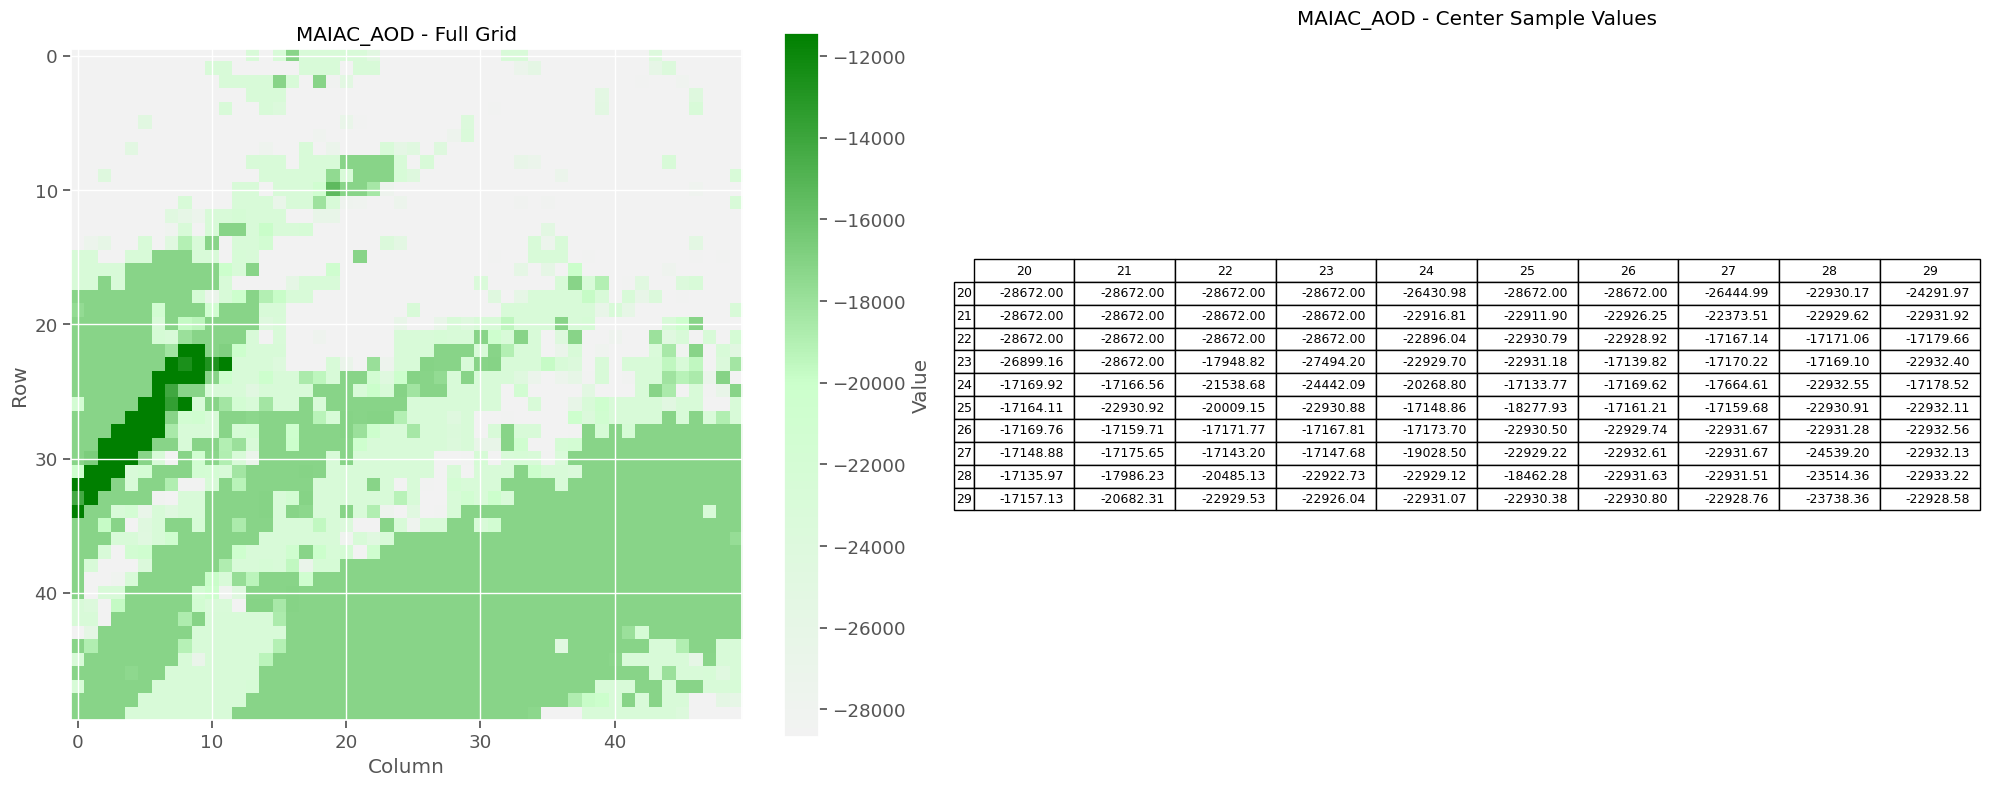


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,-28672.000000,-28672.000000,-28672.000000,-28672.000000,-26430.981258,-28672.000000,-28672.000000,-26444.989504,-22930.172595,-24291.972345
21,-28672.000000,-28672.000000,-28672.000000,-28672.000000,-22916.806997,-22911.896793,-22926.250729,-22373.507289,-22929.624490,-22931.915452
22,-28672.000000,-28672.000000,-28672.000000,-28672.000000,-22896.044065,-22930.787755,-22928.918367,-17167.144690,-17171.062391,-17179.661308
23,-26899.155185,-28672.000000,-17948.819992,-27494.197418,-22929.700625,-22931.181175,-17139.817160,-17170.223740,-17169.103790,-22932.395918
24,-17169.919034,-17166.558601,-21538.678551,-24442.094461,-20268.797418,-17133.771595,-17169.617909,-17664.606247,-22932.554519,-17178.519200
25,-17164.113953,-22930.919534,-20009.150104,-22930.877551,-17148.855893,-18277.931862,-17161.209579,-17159.684631,-22930.912536,-22932.106122
26,-17169.761766,-17159.708455,-17171.774677,-17167.807663,-17173.700541,-22930.495294,-22929.742357,-22931.673469,-22931.281633,-22932.555102
27,-17148.879300,-17175.647813,-17143.203165,-17147.678634,-19028.498709,-22929.216243,-22932.608163,-22931.665306,-24539.201166,-22932.134694
28,-17135.971429,-17986.232653,-20485.125364,-22922.734111,-22929.115452,-18462.281633,-22931.630904,-22931.511953,-23514.355102,-22933.218659


In [5]:
# Get indices for MAIAC AOD channels
maiac_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                if name in channel_info['maiac_channels']]

# Analyze each MAIAC AOD channel
for i, idx in enumerate(maiac_indices):
    channel_name = channel_info['channel_names'][idx]
    df = analyze_channel(data, idx, channel_name, colormap=cmap_green)
    display(df)

## Analyze TROPOMI Data

Next, let's examine the TROPOMI data (methane, nitrogen dioxide, and carbon monoxide).


### Channel 1: TROPOMI_Methane ###
Min: 1906.7095
Max: 1978.1853
Mean: 1945.3246
Std: 14.2019
Data coverage: 100.00% (2500/2500 non-zero pixels)


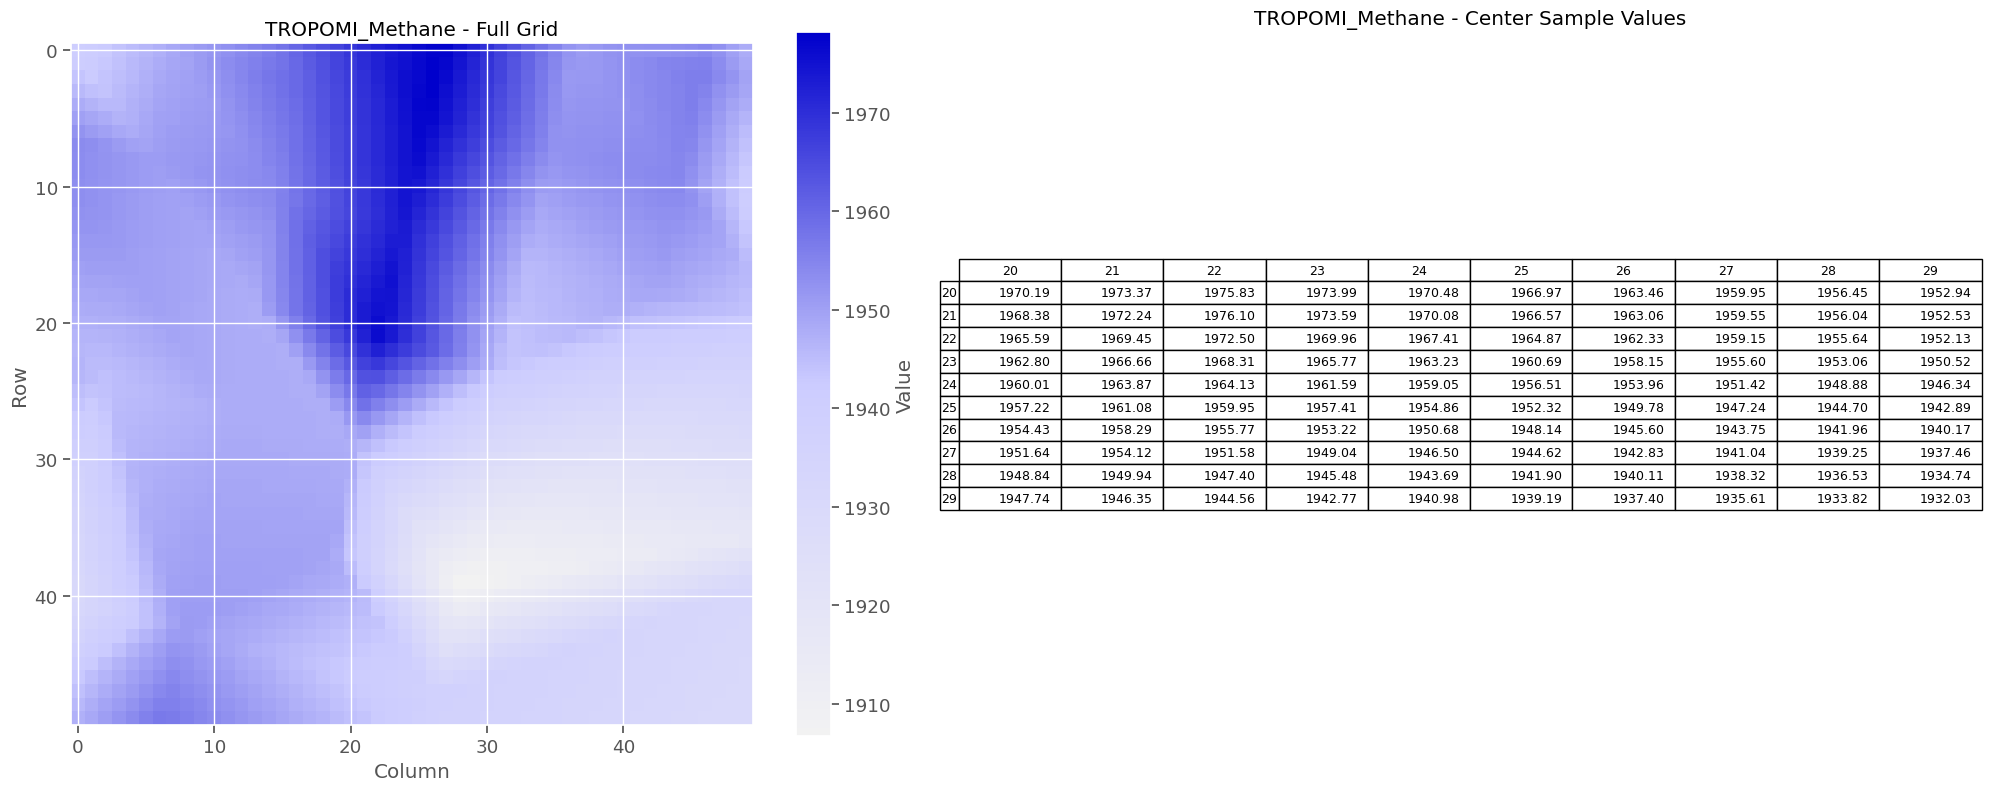


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,1970.186800,1973.365759,1975.832546,1973.989473,1970.480600,1966.971727,1963.462854,1959.953981,1956.445108,1952.942803
21,1968.378914,1972.239192,1976.099470,1973.588092,1970.079220,1966.570347,1963.061474,1959.552601,1956.043728,1952.534855
22,1965.588319,1969.448597,1972.498072,1969.955911,1967.413750,1964.871589,1962.329428,1959.151220,1955.642347,1952.133475
23,1962.797724,1966.658002,1968.314916,1965.772756,1963.230595,1960.688434,1958.146273,1955.604112,1953.061952,1950.519791
24,1960.007129,1963.867407,1964.131761,1961.589600,1959.047440,1956.505279,1953.963118,1951.420957,1948.878796,1946.336636
25,1957.216534,1961.076812,1959.948606,1957.406445,1954.864284,1952.322124,1949.779963,1947.237802,1944.695641,1942.885172
26,1954.425939,1958.286217,1955.765451,1953.223290,1950.681129,1948.138968,1945.596807,1943.750590,1941.960555,1940.170520
27,1951.635344,1954.124456,1951.582295,1949.040135,1946.497974,1944.616008,1942.825973,1941.035938,1939.245903,1937.455867
28,1948.844749,1949.941301,1947.399140,1945.481426,1943.691391,1941.901356,1940.111321,1938.321286,1936.531250,1934.741215



### Channel 2: TROPOMI_NO2 ###
Min: 0.0001
Max: 0.0005
Mean: 0.0003
Std: 0.0001
Data coverage: 100.00% (2500/2500 non-zero pixels)


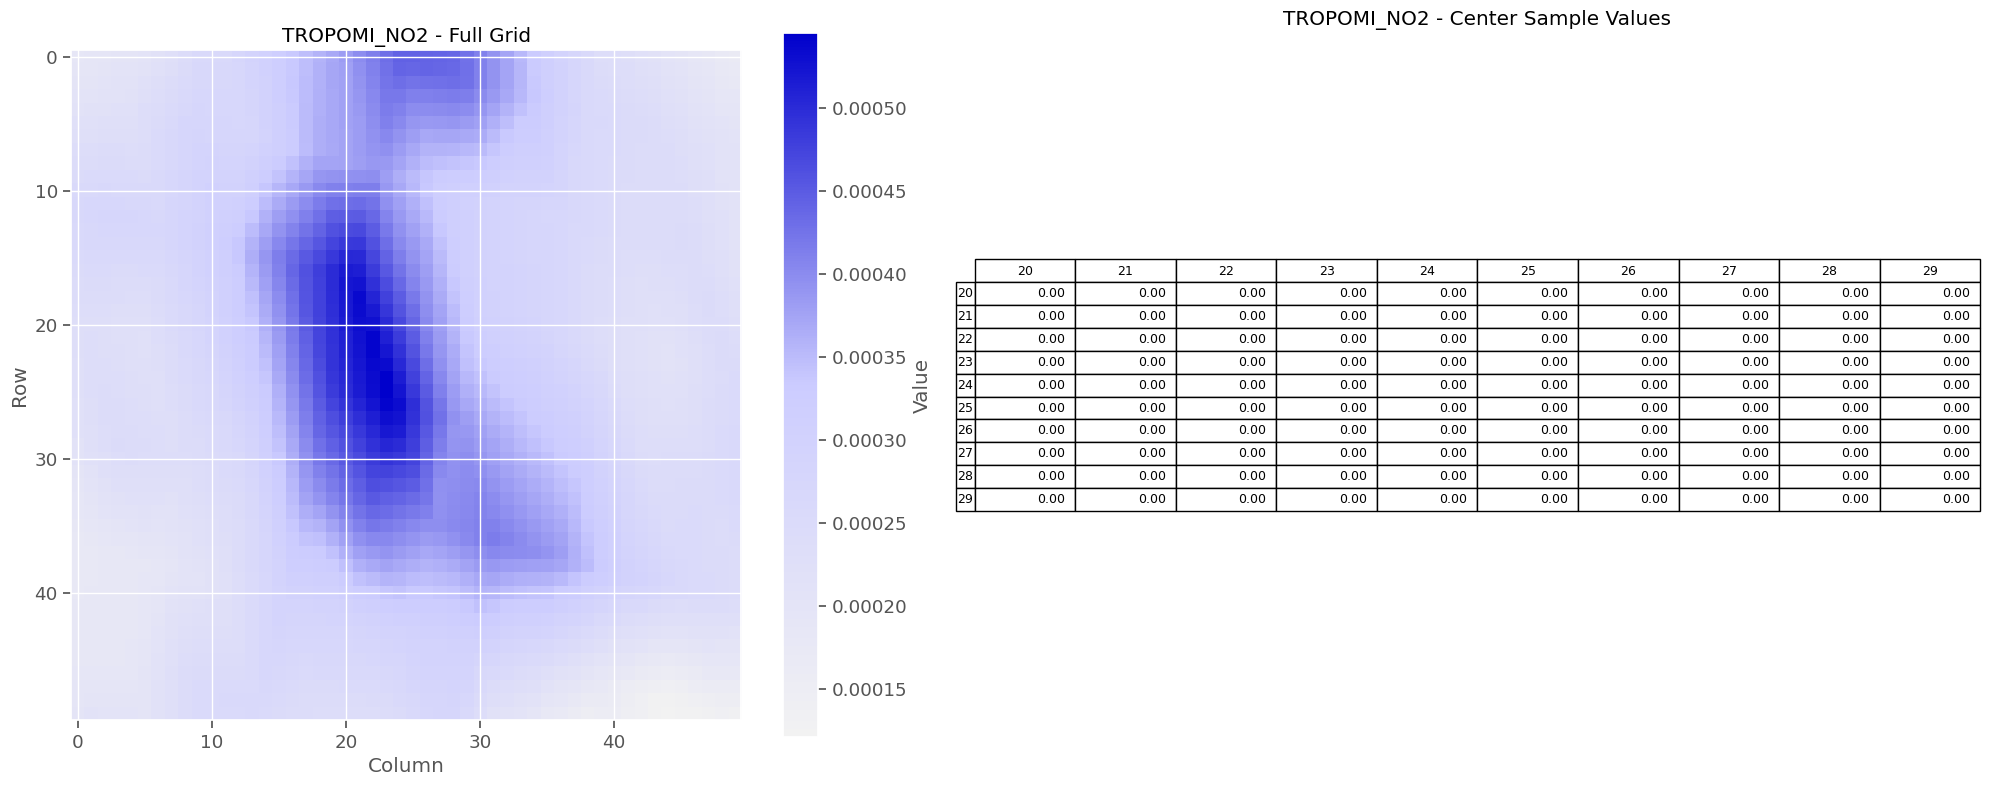


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.000515,0.000529,0.000528,0.000499,0.000470,0.000439,0.000402,0.000378,0.000354,0.000330
21,0.000512,0.000527,0.000539,0.000510,0.000481,0.000448,0.000411,0.000384,0.000359,0.000335
22,0.000509,0.000524,0.000539,0.000521,0.000492,0.000458,0.000421,0.000389,0.000365,0.000340
23,0.000506,0.000521,0.000536,0.000533,0.000503,0.000467,0.000430,0.000394,0.000370,0.000346
24,0.000503,0.000518,0.000533,0.000544,0.000514,0.000477,0.000440,0.000403,0.000376,0.000354
25,0.000499,0.000515,0.000530,0.000545,0.000523,0.000486,0.000449,0.000412,0.000381,0.000362
26,0.000490,0.000506,0.000523,0.000540,0.000531,0.000496,0.000459,0.000422,0.000387,0.000371
27,0.000480,0.000496,0.000513,0.000530,0.000525,0.000492,0.000459,0.000426,0.000393,0.000379
28,0.000470,0.000487,0.000503,0.000520,0.000514,0.000486,0.000453,0.000420,0.000389,0.000386



### Channel 3: TROPOMI_CO ###
Min: 0.0241
Max: 0.0406
Mean: 0.0350
Std: 0.0032
Data coverage: 100.00% (2500/2500 non-zero pixels)


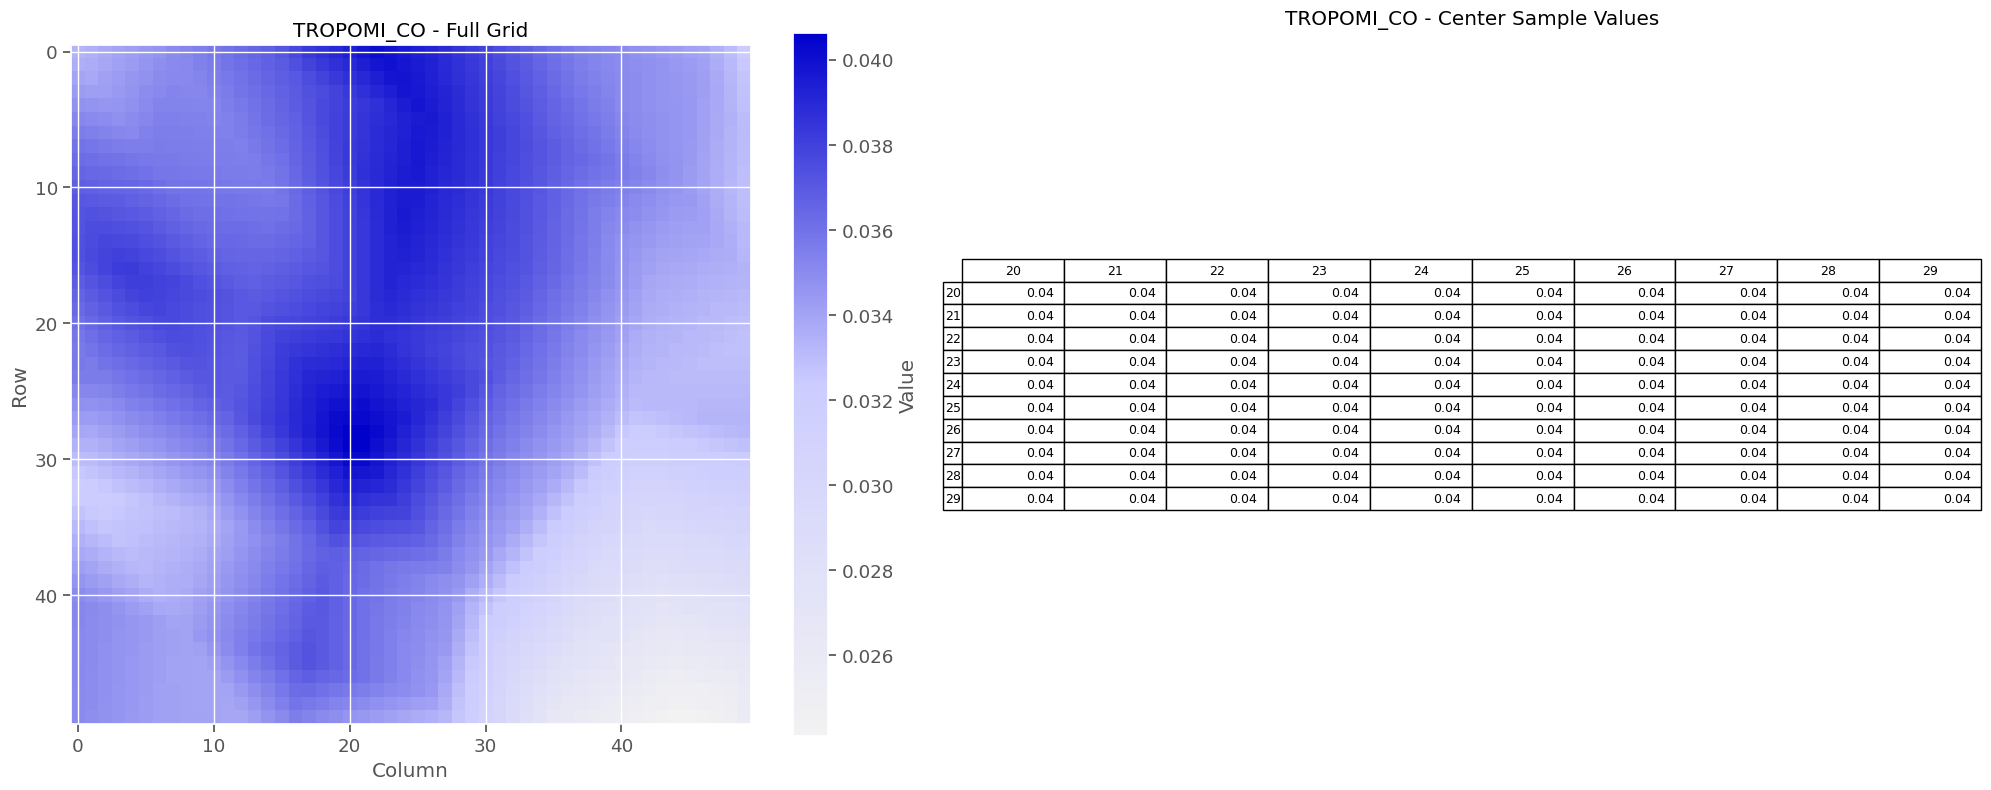


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.038308,0.038452,0.038751,0.038762,0.038590,0.038417,0.038244,0.038071,0.037898,0.037725
21,0.038559,0.038681,0.038802,0.038627,0.038454,0.038281,0.038108,0.037935,0.037763,0.037590
22,0.038844,0.038966,0.039039,0.038780,0.038520,0.038261,0.038002,0.037799,0.037627,0.037454
23,0.039130,0.039251,0.039241,0.038982,0.038723,0.038463,0.038204,0.037945,0.037686,0.037426
24,0.039415,0.039536,0.039444,0.039185,0.038925,0.038666,0.038407,0.038147,0.037888,0.037629
25,0.039700,0.039821,0.039646,0.039387,0.039128,0.038868,0.038609,0.038350,0.038090,0.037607
26,0.039985,0.040107,0.039849,0.039589,0.039330,0.039071,0.038811,0.038339,0.037850,0.037360
27,0.040270,0.040310,0.040051,0.039792,0.039532,0.039071,0.038582,0.038092,0.037603,0.037113
28,0.040556,0.040513,0.040253,0.039803,0.039314,0.038824,0.038335,0.037845,0.037356,0.036866


In [6]:
# Get indices for TROPOMI channels
tropomi_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                  if name in channel_info['tropomi_channels']]

# Analyze each TROPOMI channel
for i, idx in enumerate(tropomi_indices):
    channel_name = channel_info['channel_names'][idx]
    df = analyze_channel(data, idx, channel_name)
    display(df)

## Analyze MODIS Fire Data

Now, let's examine the MODIS Fire Radiative Power (FRP) data.


### Channel 4: MODIS_FRP ###
Min: 0.0000
Max: 0.5157
Mean: 0.1695
Std: 0.1732
Data coverage: 89.52% (2238/2500 non-zero pixels)


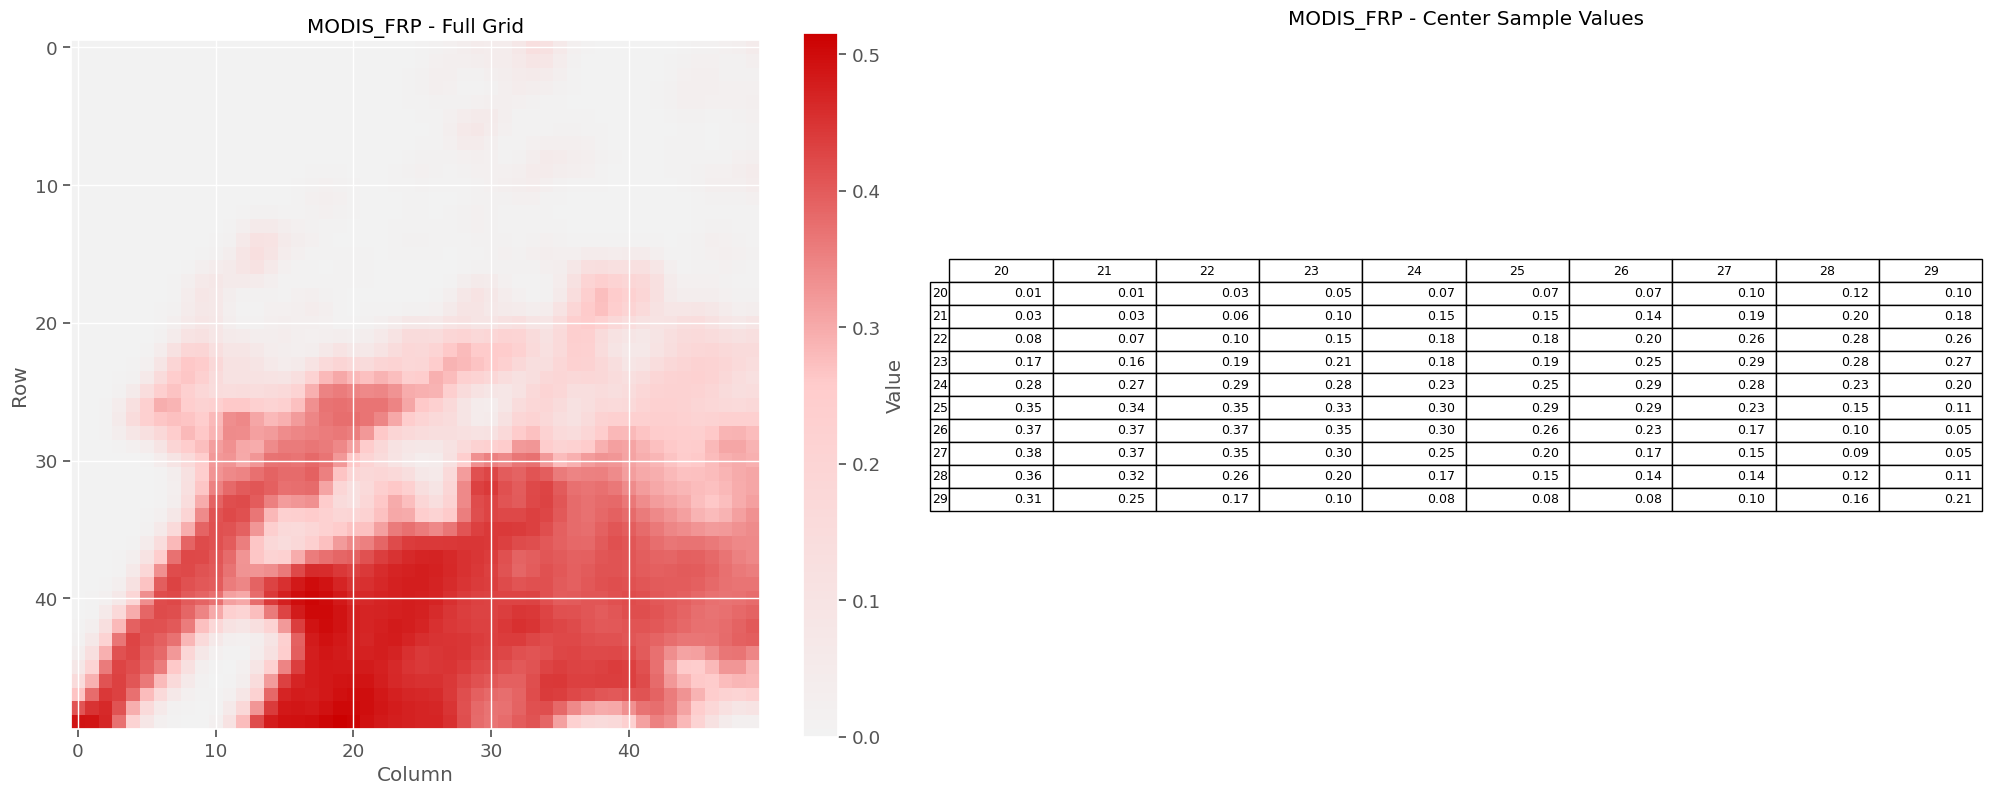


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.006937,0.013793,0.027312,0.045801,0.073002,0.074716,0.068259,0.097677,0.115859,0.096357
21,0.027331,0.031748,0.059338,0.101888,0.154953,0.154357,0.143892,0.188362,0.202633,0.176910
22,0.075227,0.065495,0.102329,0.147428,0.178944,0.176893,0.198260,0.261233,0.279061,0.259188
23,0.168759,0.155411,0.191607,0.206089,0.181958,0.190970,0.248109,0.288239,0.281175,0.269695
24,0.283866,0.273921,0.289034,0.275313,0.233185,0.249714,0.292159,0.276951,0.225867,0.204313
25,0.346663,0.342321,0.345616,0.329966,0.297037,0.292439,0.289274,0.234314,0.153863,0.107165
26,0.368304,0.367305,0.367449,0.348425,0.304620,0.260049,0.225692,0.170846,0.095599,0.046399
27,0.375208,0.367442,0.346253,0.303375,0.250485,0.197807,0.170070,0.146715,0.092365,0.047343
28,0.355400,0.322395,0.260930,0.195690,0.165348,0.147251,0.136477,0.135321,0.120824,0.106102


In [7]:
# Get indices for MODIS Fire channels
modis_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                if name in channel_info['modis_fire_channels']]

# Analyze each MODIS Fire channel
for i, idx in enumerate(modis_indices):
    channel_name = channel_info['channel_names'][idx]
    df = analyze_channel(data, idx, channel_name, colormap=cmap_red)
    display(df)

## Analyze MERRA-2 Data

Next, let's examine the MERRA-2 data (PBL Height, Surface Air Temperature, and Surface Exchange Coefficient).


### Channel 5: MERRA2_PBL_Height ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/2500 non-zero pixels)


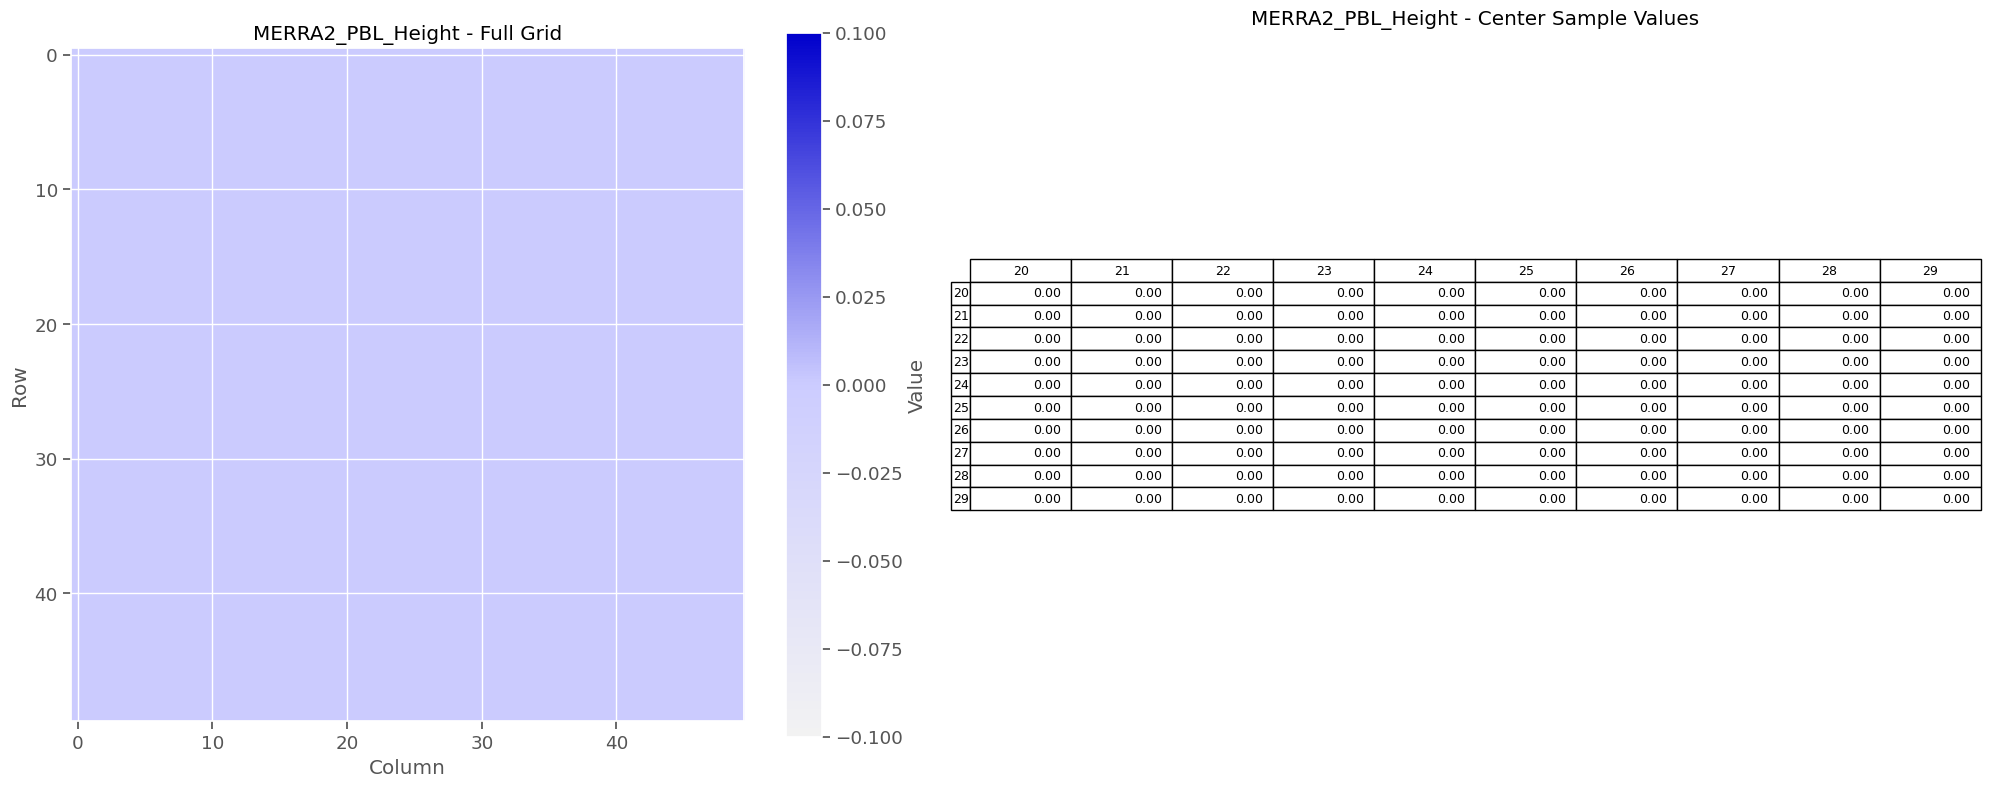


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 6: MERRA2_Surface_Air_Temp ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/2500 non-zero pixels)


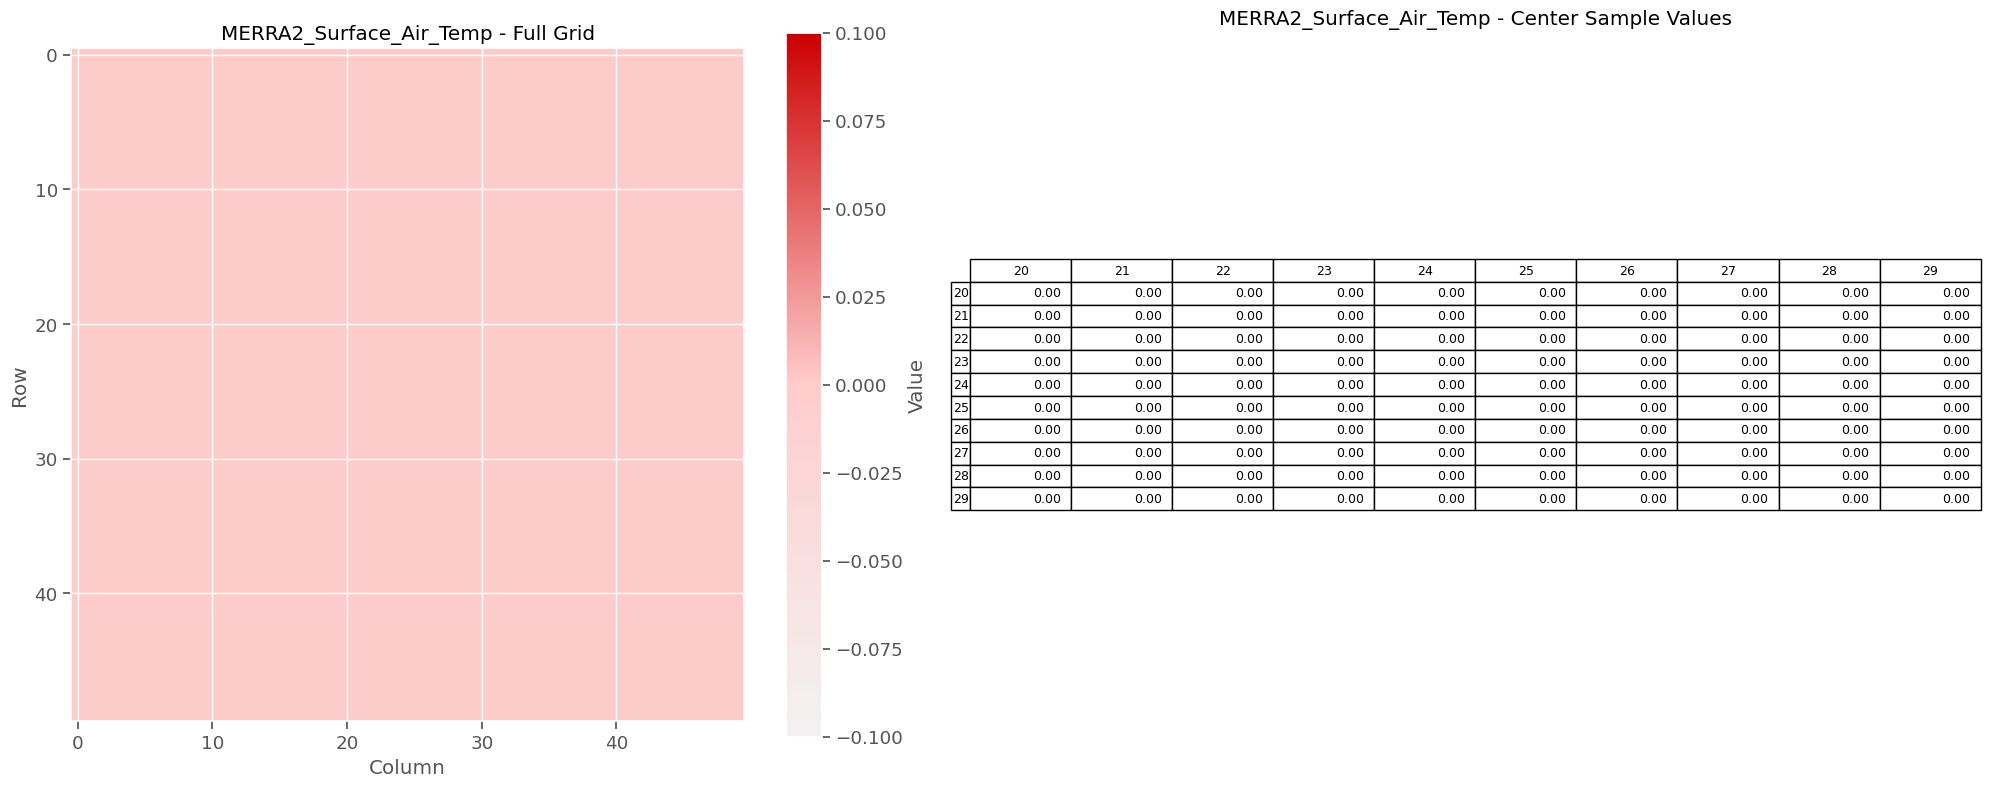


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 7: MERRA2_Surface_Exchange_Coef ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/2500 non-zero pixels)


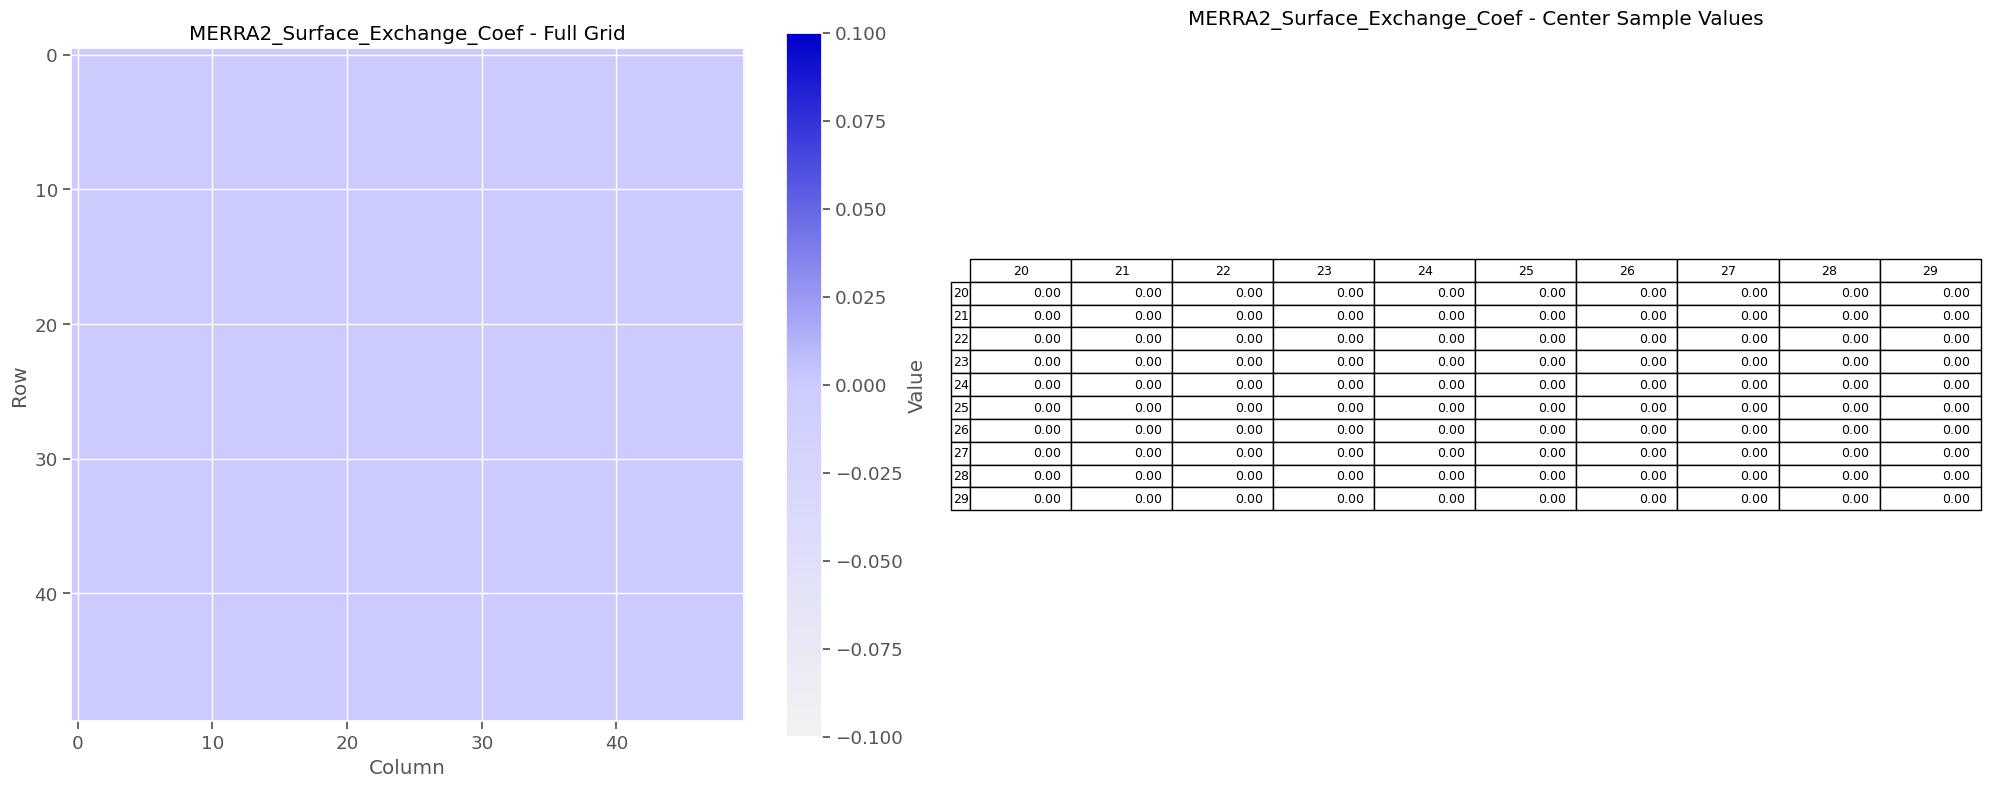


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Get indices for MERRA-2 channels
merra2_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                 if name in channel_info['merra2_channels']]

# Analyze each MERRA-2 channel
for i, idx in enumerate(merra2_indices):
    channel_name = channel_info['channel_names'][idx]
    
    # Use red colormap for temperature
    if 'Temp' in channel_name:
        cmap = cmap_red
    else:
        cmap = cmap_blue
        
    df = analyze_channel(data, idx, channel_name, colormap=cmap)
    display(df)

## Analyze METAR Meteorological Data

Finally, let's examine the METAR meteorological data.


### Channel 8: METAR_Wind_Speed ###
Min: 3.7827
Max: 5.2548
Mean: 4.4419
Std: 0.1633
Data coverage: 100.00% (2500/2500 non-zero pixels)


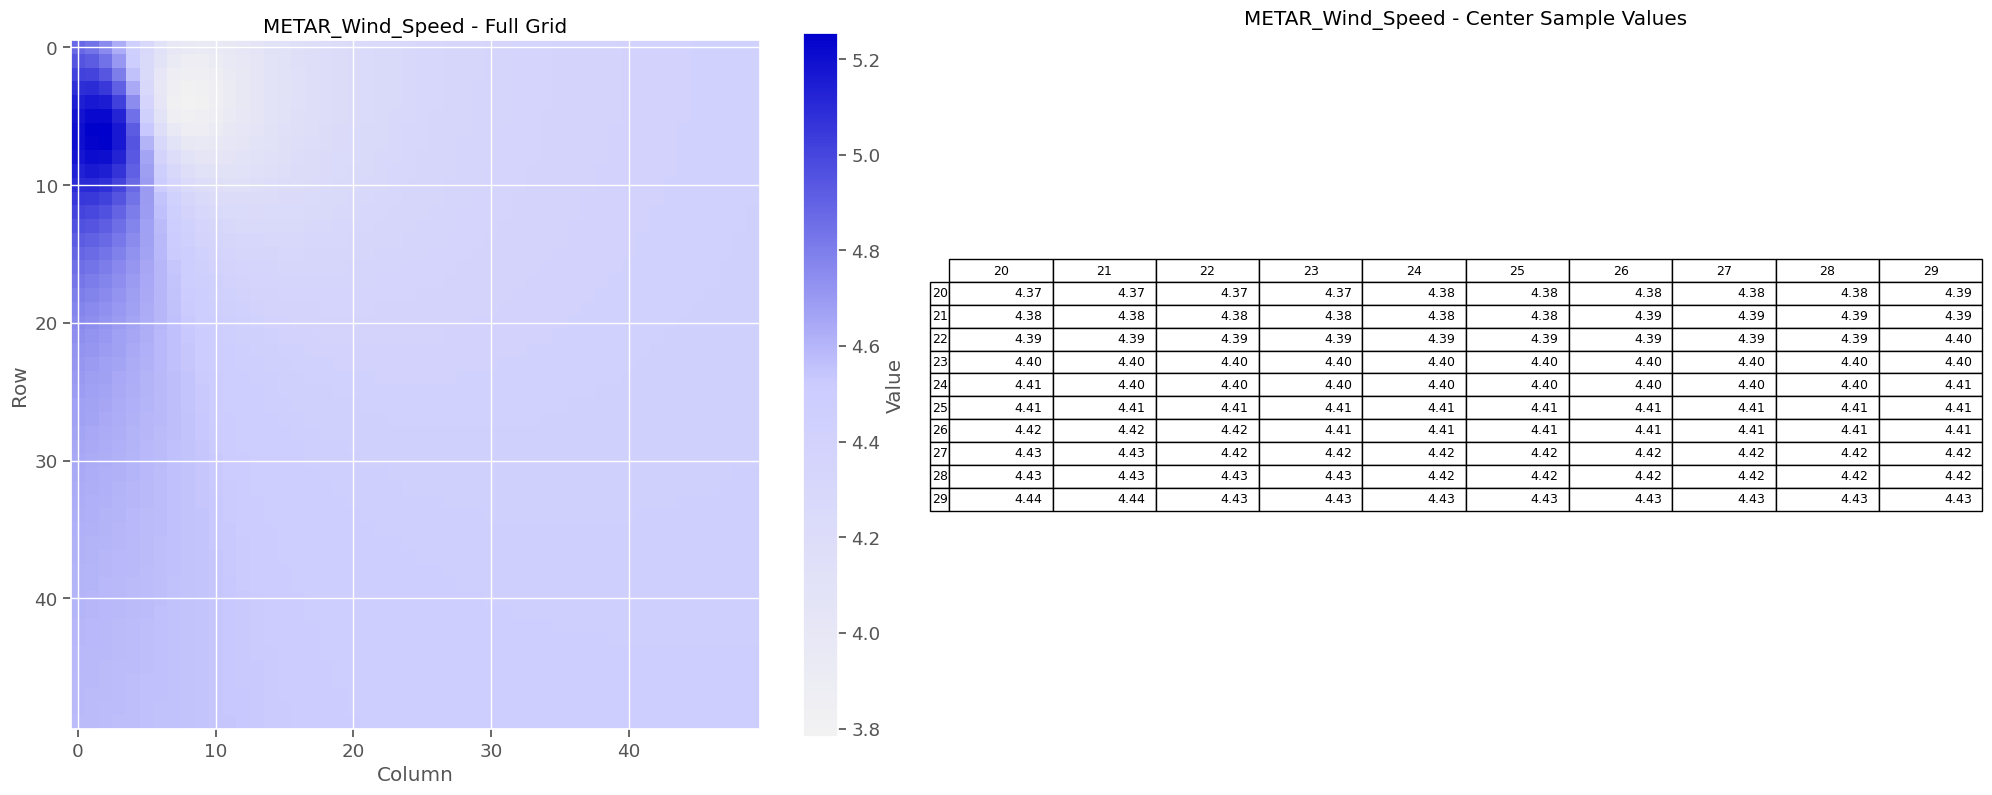


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,4.371886,4.371966,4.372721,4.373997,4.375670,4.377639,4.379826,4.382166,4.384609,4.387115
21,4.381332,4.380698,4.380777,4.381421,4.382508,4.383938,4.385630,4.387518,4.389549,4.391681
22,4.390325,4.389071,4.388551,4.388626,4.389179,4.390112,4.391343,4.392807,4.394448,4.396221
23,4.398853,4.397065,4.396021,4.395589,4.395659,4.396137,4.396943,4.398010,4.399284,4.400718
24,4.406913,4.404672,4.403172,4.402293,4.401931,4.401995,4.402410,4.403111,4.404041,4.405156
25,4.414509,4.411889,4.409998,4.408727,4.407980,4.407672,4.407731,4.408094,4.408706,4.409522
26,4.421652,4.418718,4.416494,4.414884,4.413797,4.413157,4.412894,4.412947,4.413265,4.413804
27,4.428356,4.425166,4.422664,4.420761,4.419378,4.418442,4.417889,4.417661,4.417710,4.417991
28,4.434637,4.431243,4.428510,4.426359,4.424719,4.423522,4.422710,4.422229,4.422031,4.422075



### Channel 9: METAR_Wind_Direction ###
Min: 248.7018
Max: 281.3930
Mean: 266.7543
Std: 3.6254
Data coverage: 100.00% (2500/2500 non-zero pixels)


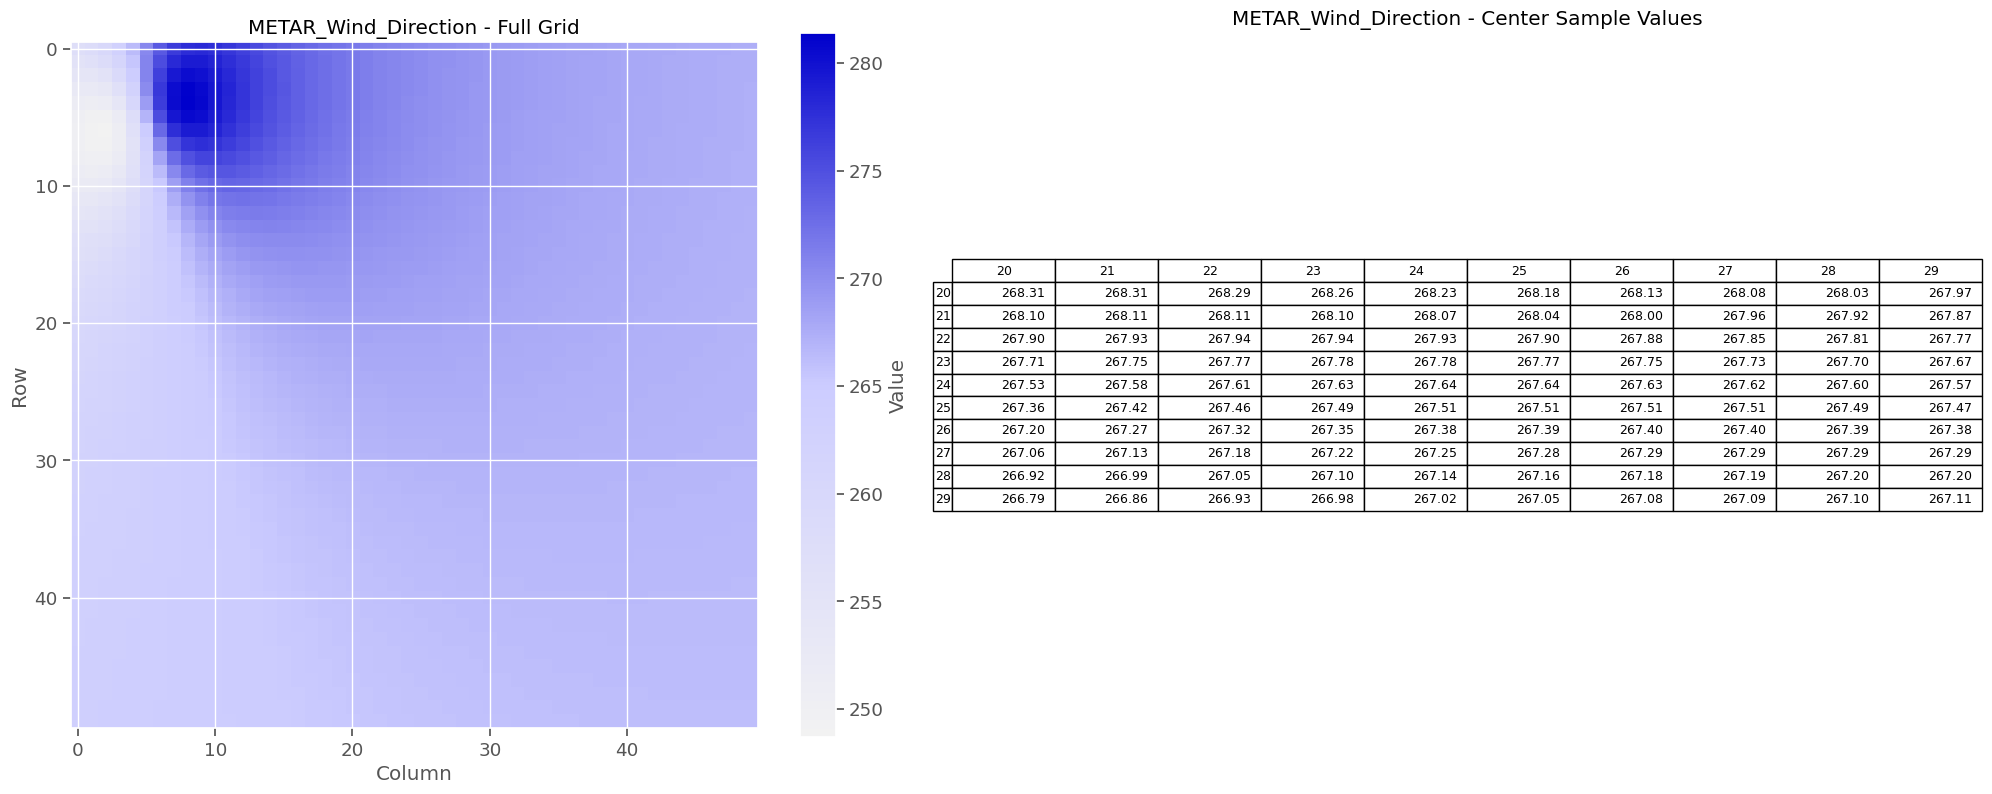


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,268.309655,268.307882,268.291118,268.262780,268.225630,268.181890,268.133333,268.081369,268.027117,267.971456
21,268.099886,268.113963,268.112210,268.097910,268.073771,268.042010,268.004433,267.962503,267.917399,267.870070
22,267.900179,267.928034,267.939575,267.937904,267.925626,267.904913,267.877565,267.845063,267.808625,267.769243
23,267.710798,267.750494,267.773692,267.783276,267.781718,267.771110,267.753216,267.729512,267.701224,267.669373
24,267.531809,267.581561,267.614873,267.634399,267.642448,267.641013,267.631796,267.616242,267.595572,267.570811
25,267.363113,267.421299,267.463298,267.491524,267.508116,267.514945,267.513635,267.505584,267.491986,267.473860
26,267.204491,267.269650,267.319027,267.354799,267.378924,267.393145,267.398993,267.397804,267.390735,267.378784
27,267.055625,267.126458,267.182028,267.224281,267.254997,267.275781,267.288065,267.293114,267.292037,267.285802
28,266.916135,266.991495,267.052193,267.099955,267.136386,267.162955,267.180988,267.191675,267.196067,267.195094



### Channel 10: METAR_Precipitation ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/2500 non-zero pixels)


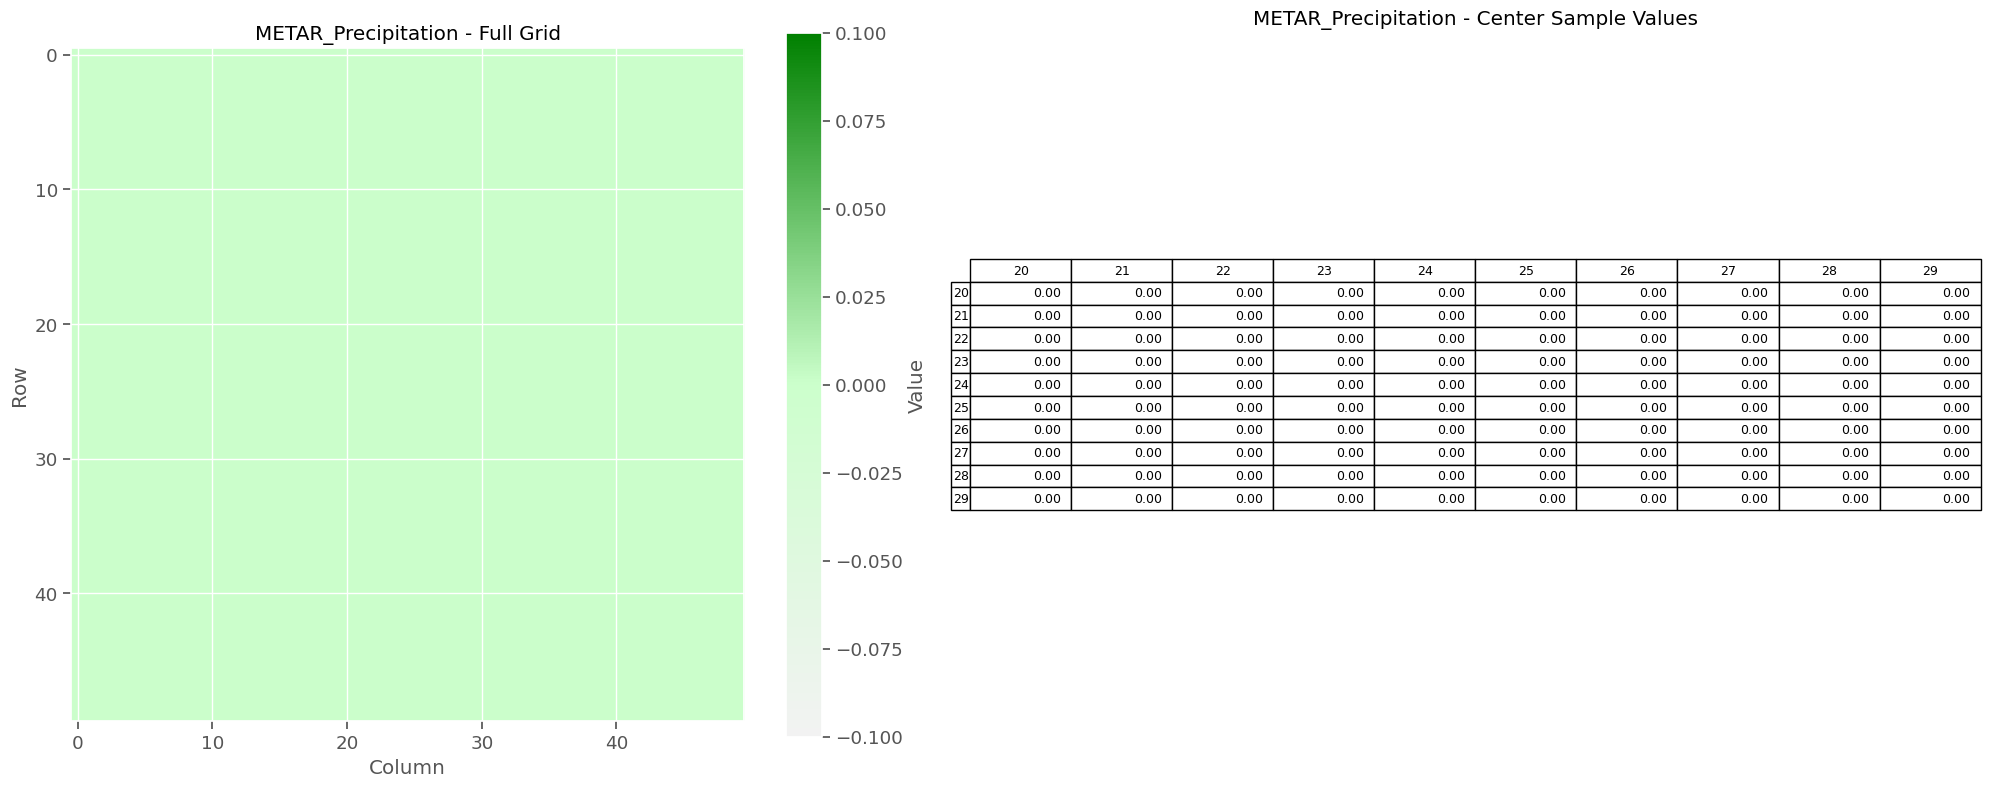


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 11: METAR_AQI ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/2500 non-zero pixels)


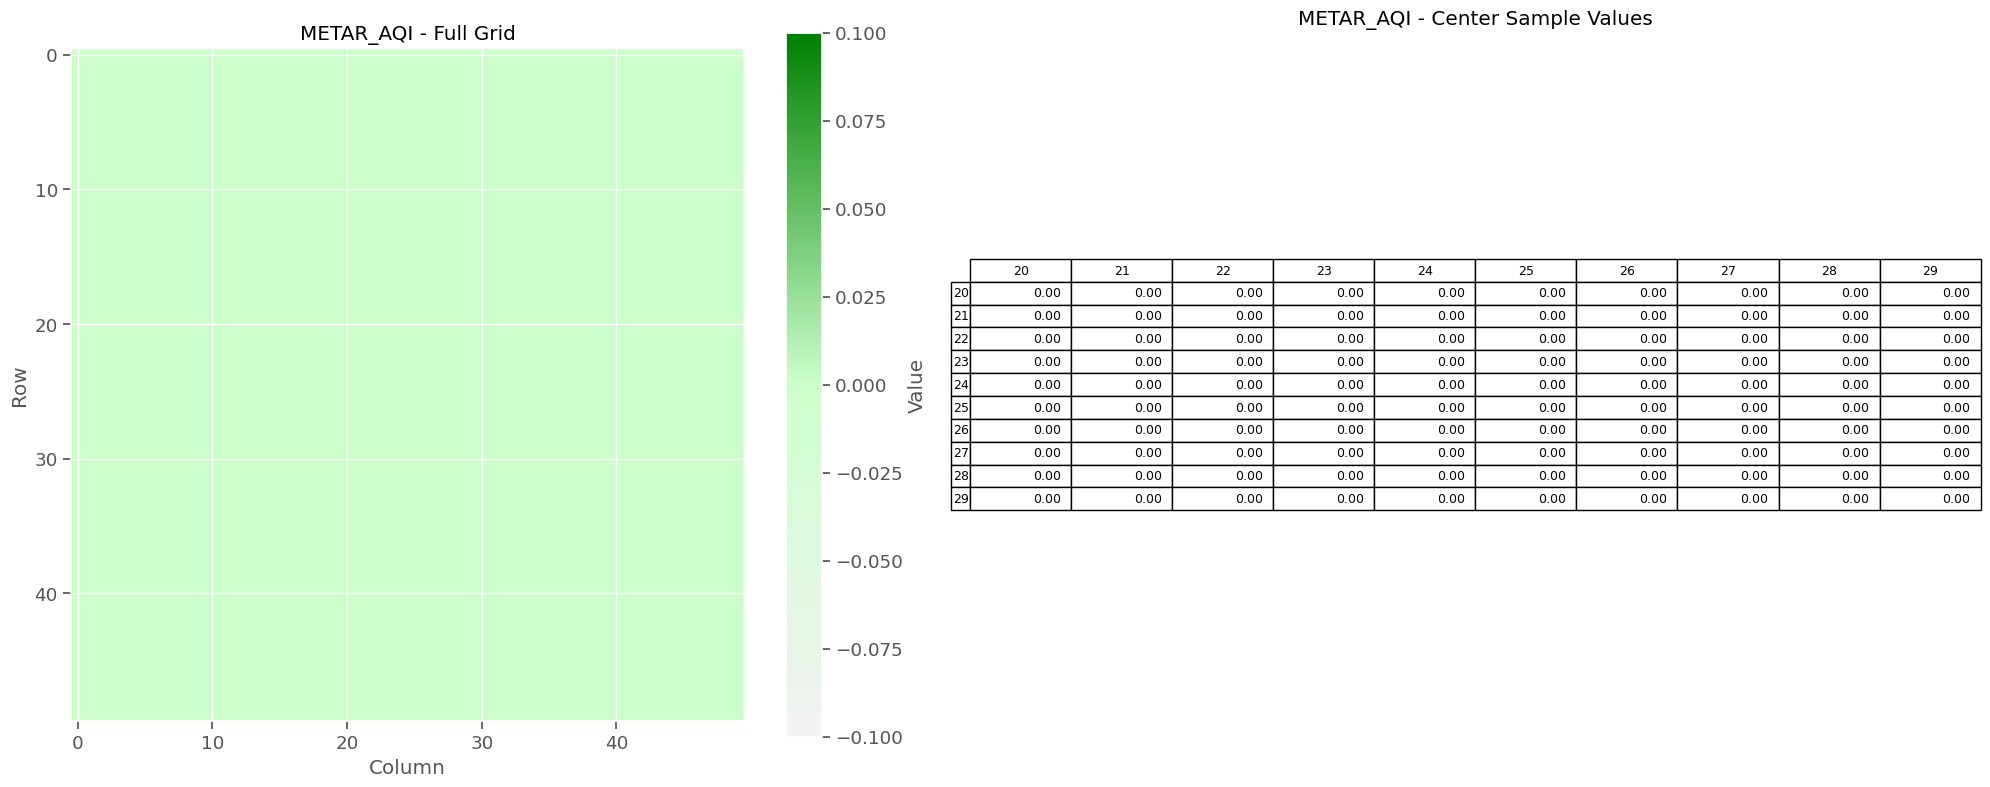


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 12: METAR_Humidity ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/2500 non-zero pixels)


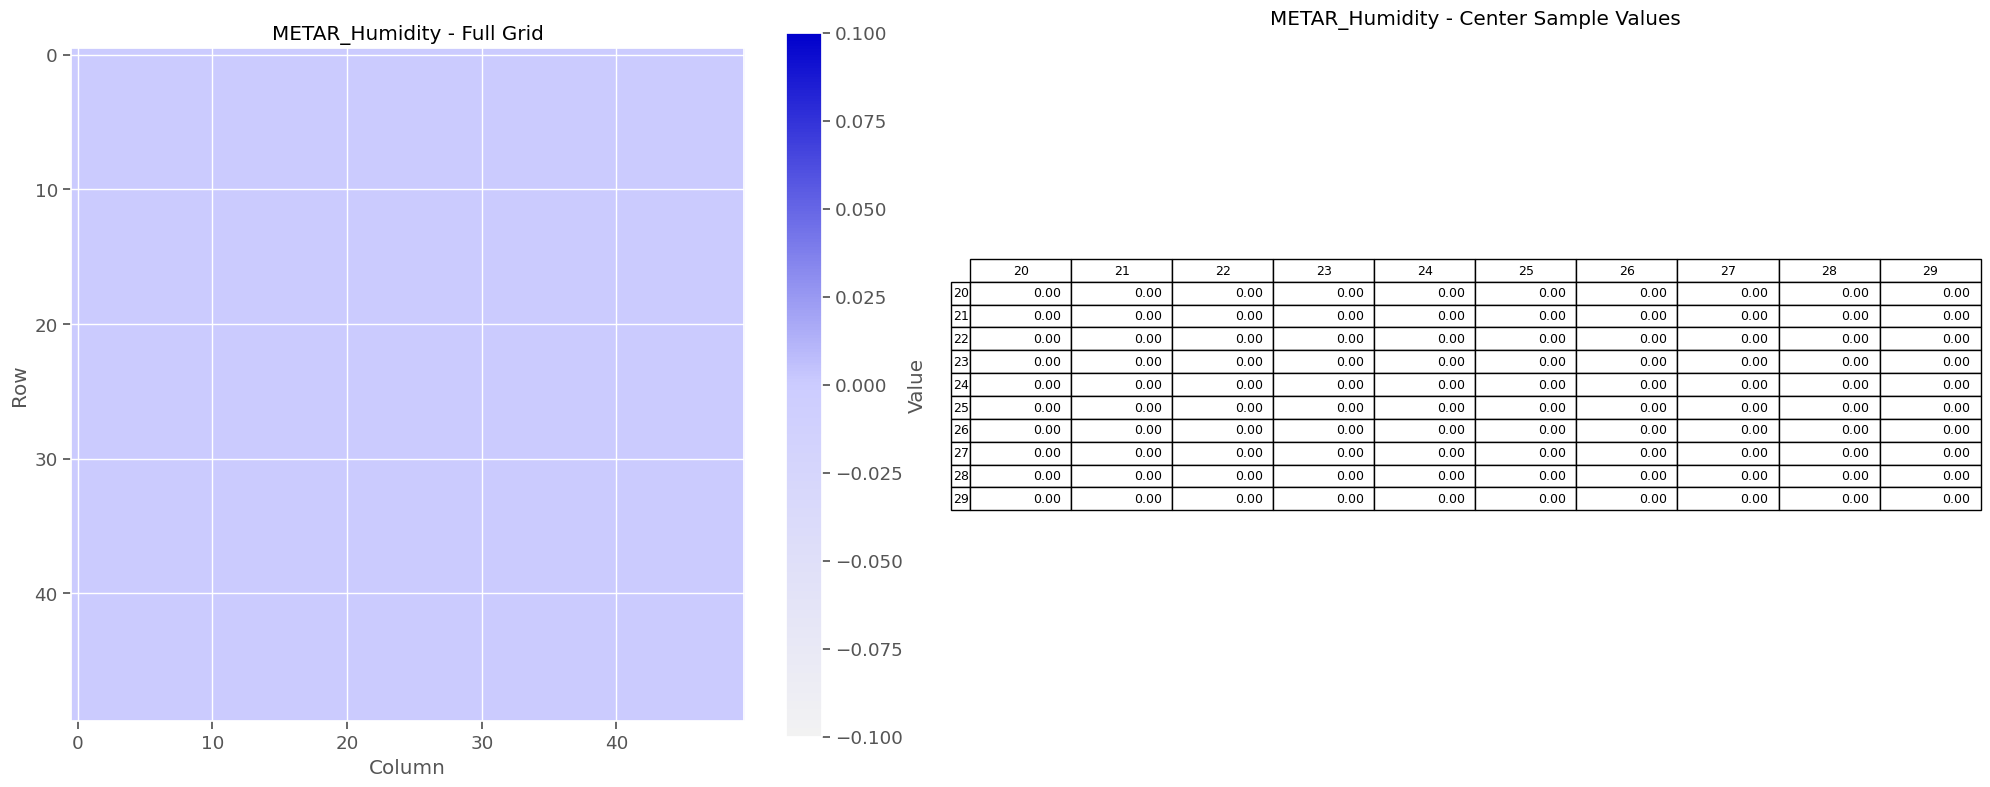


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 13: METAR_Heat_Index ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/2500 non-zero pixels)


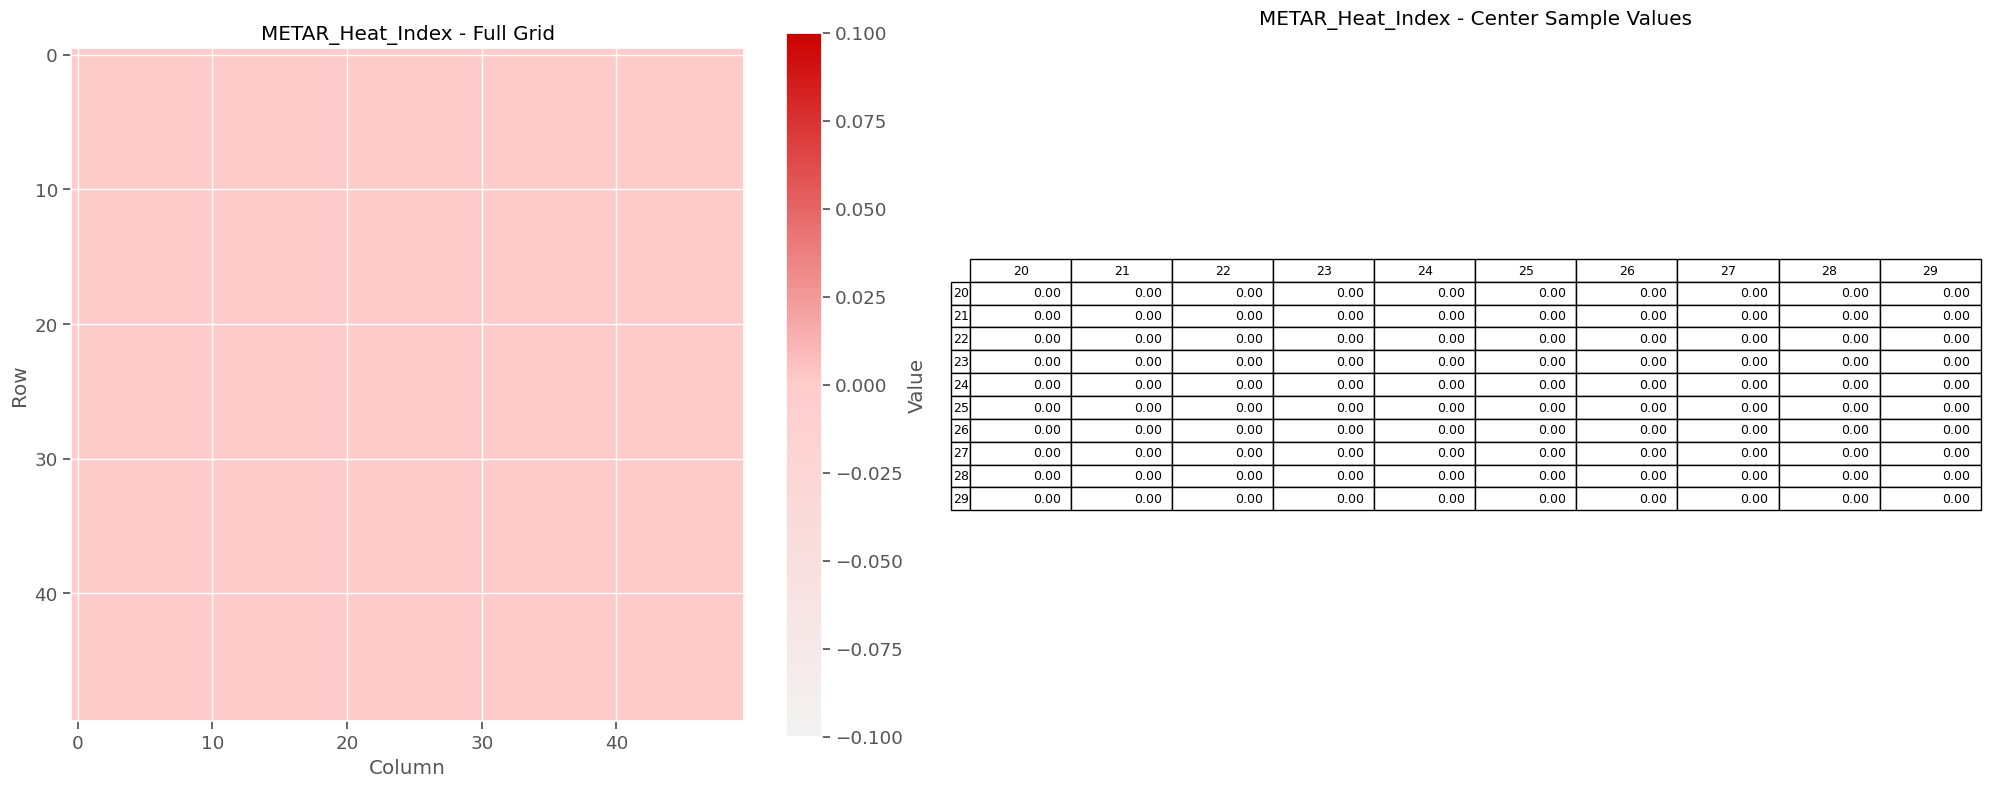


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 14: METAR_Air_Temp ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/2500 non-zero pixels)


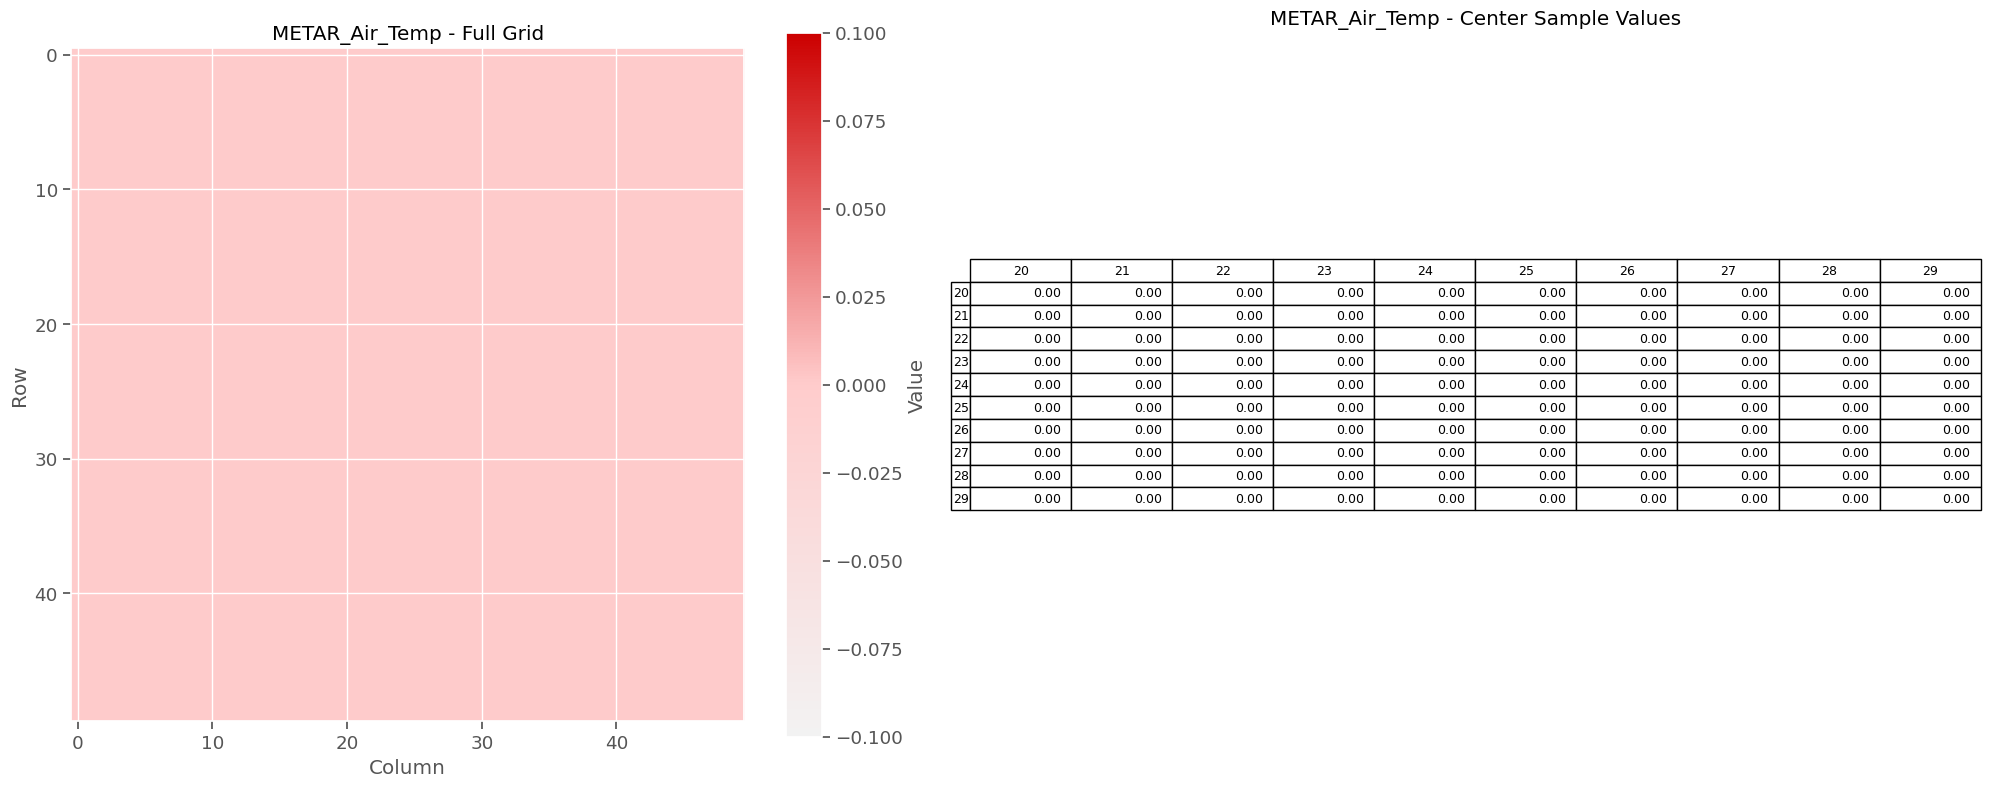


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 15: METAR_Air_Pressure ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/2500 non-zero pixels)


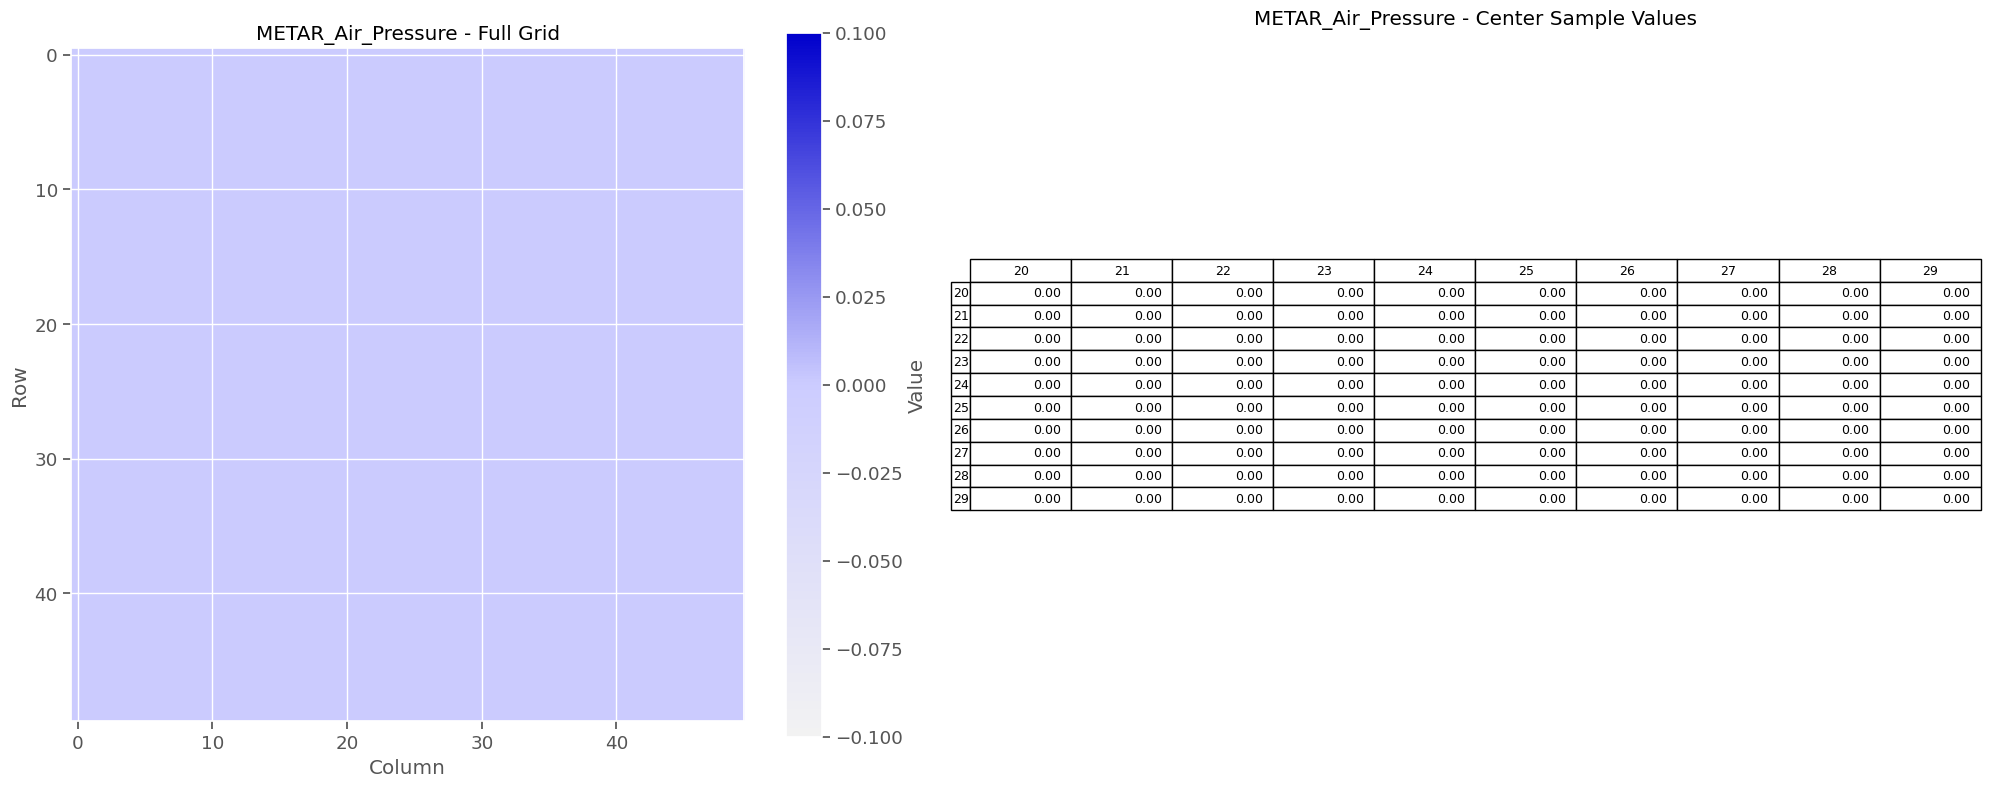


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 16: METAR_Dew_Point ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/2500 non-zero pixels)


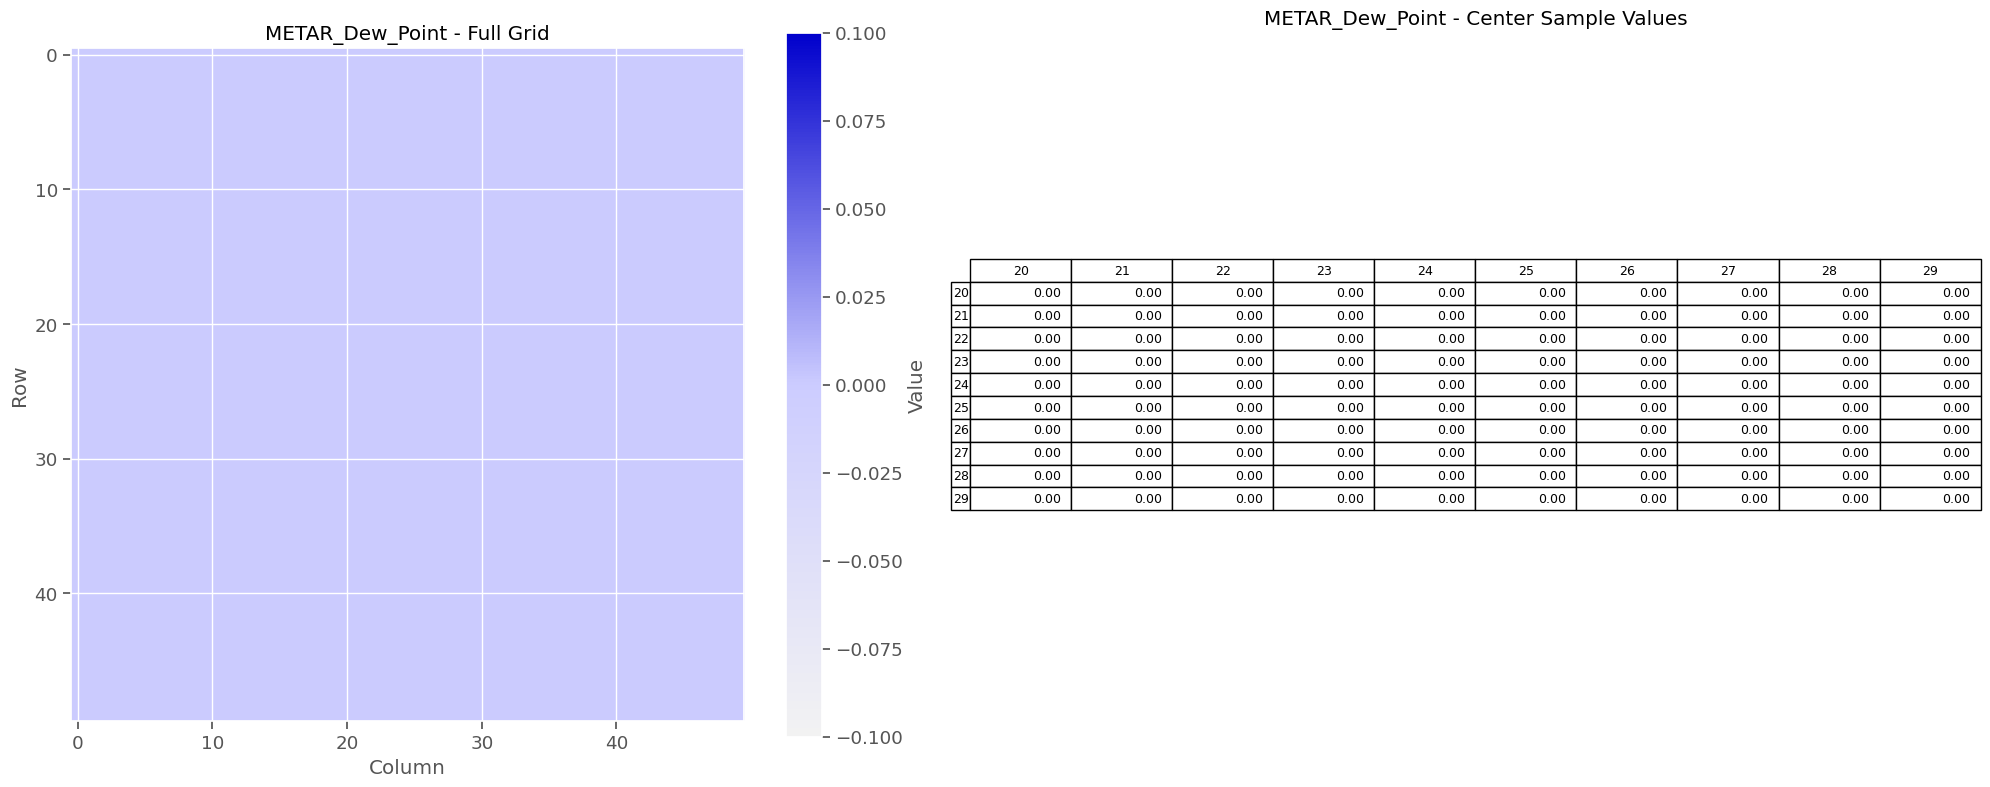


Center sample data:


Column,20,21,22,23,24,25,26,27,28,29
Row,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Get indices for METAR channels
metar_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                if name in channel_info['metar_channels']]

# Analyze each METAR channel
for i, idx in enumerate(metar_indices):
    channel_name = channel_info['channel_names'][idx]
    
    # Use appropriate colormap based on channel content
    if any(term in channel_name for term in ['Temp', 'Heat']):
        cmap = cmap_red
    elif any(term in channel_name for term in ['AQI', 'Precipitation']):
        cmap = cmap_green
    else:
        cmap = cmap_blue
        
    df = analyze_channel(data, idx, channel_name, colormap=cmap)
    display(df)

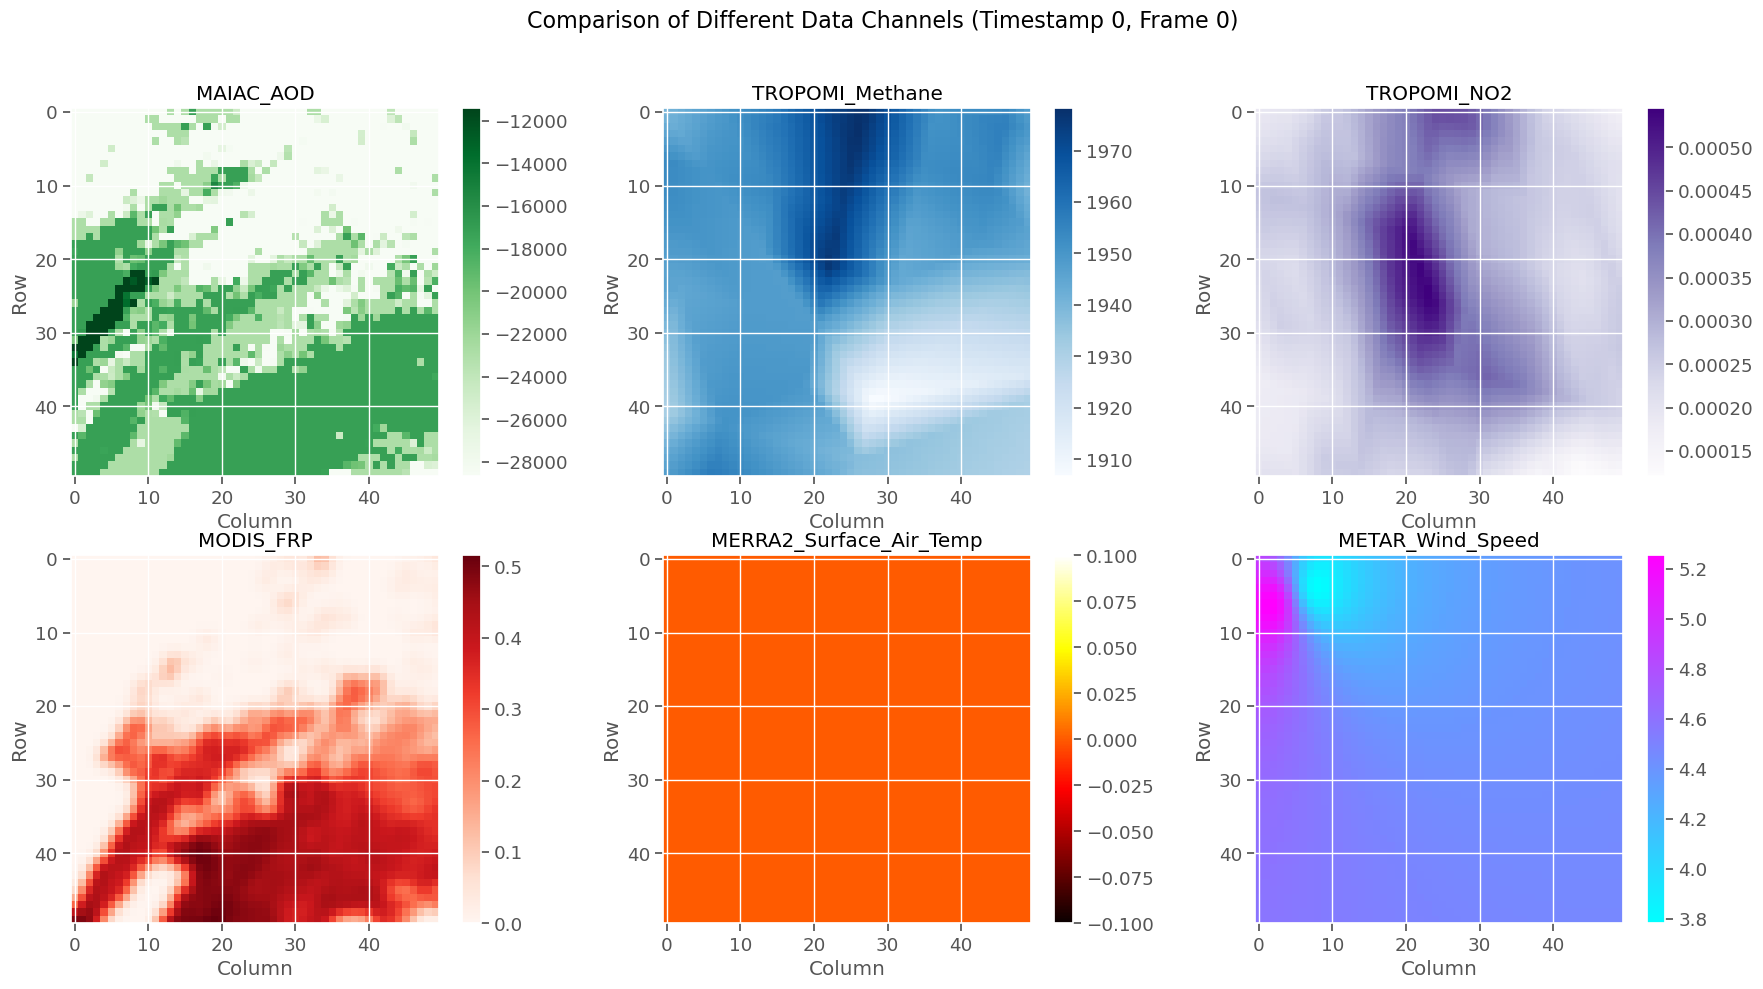

In [20]:
# Compare different data channels at the same timestamp/frame
timestamp_idx = 0
frame_idx = 0

# Get channel information
channel_info = data.get_channel_info()

# Select diverse channels to compare
channels_to_compare = [
    ('MAIAC_AOD', 0),                # Aerosol optical depth
    ('TROPOMI_Methane', 1),          # Methane concentration
    ('TROPOMI_NO2', 2),              # Nitrogen dioxide
    ('MODIS_FRP', 3),                # Fire radiative power
    ('MERRA2_Surface_Air_Temp', 5),  # Temperature
    ('METAR_Wind_Speed', 7)          # Wind speed
]

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Select appropriate colormaps for different variables
cmaps = {
    'MAIAC_AOD': 'Greens',
    'TROPOMI_Methane': 'Blues', 
    'TROPOMI_NO2': 'Purples',
    'MODIS_FRP': 'Reds',
    'MERRA2_Surface_Air_Temp': 'hot',
    'METAR_Wind_Speed': 'cool'
}

# Plot each channel
for i, (channel_name, channel_offset) in enumerate(channels_to_compare):
    if i < len(axes):
        # Find the actual channel index
        channel_idx = channel_offset  # Default to offset
        for j, name in enumerate(channel_info['channel_names']):
            if name == channel_name:
                channel_idx = j
                break
        
        # Get data for this channel
        channel_data = data.data[timestamp_idx, frame_idx, :, :, channel_idx]
        
        # Display the data
        im = axes[i].imshow(channel_data, cmap=cmaps.get(channel_name, 'viridis'))
        axes[i].set_title(f"{channel_name}")
        axes[i].set_xlabel('Column')
        axes[i].set_ylabel('Row')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[i])

plt.suptitle(f"Comparison of Different Data Channels (Timestamp {timestamp_idx}, Frame {frame_idx})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()